In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [4]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 8

GEN_IN_CHANNELS = 1
GEN_N_CLASSES = 1

DIS_IN_CHANNELS = 1
DIS_N_CLASSES = 2

E_IN_CHANNELS = 1
E_N_CLASSES = 2

EPOCH = 200

### Model Settings

#### encoder

In [5]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [6]:
DECODER_ATT = "scse"

#### head

In [7]:
GEN_ACT = "sigmoid"
DIS_ACT = "softmax"
E_ACT = "softmax"

### Optimizer Settings

In [8]:
GEN_OPTIM_NAME = "adam"
GEN_init_lr = 1e-4
GEN_momentum = 0.9

In [9]:
DIS_OPTIM_NAME = "adam"
DIS_init_lr = 1e-2
DIS_momentum = 0.9
DIS_scheduler = "cosineAnnWarm"

In [10]:
E_OPTIM_NAME = "adam"
E_init_lr = 1e-2
E_momentum = 0.9
E_scheduler = "cosineAnnWarm"

# Epochs

In [11]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR, ContourEval
from codes.activation import Activation
from codes.utils import hu_clip_tensor
from codes.losses import PerceptualLoss
from kornia.filters.sobel import Sobel

In [12]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
    nets (network list)   -- a list of networks
    requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

In [13]:
def replace_relu_to_leakyReLU(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, nn.LeakyReLU())
        else:
            replace_relu_to_leakyReLU(child)

In [14]:
def replace_bn_to_instanceNorm(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.BatchNorm2d):
            bn = getattr(model, child_name)
            setattr(model, child_name, nn.InstanceNorm2d(bn.num_features))
        else:
            replace_bn_to_instanceNorm(child)

In [15]:
perceptual_ext = PerceptualLoss()

In [16]:
sobel_filter = Sobel().to(device)

In [17]:
def train_a2b_epoch(epoch, generator, gen_optim, 
                    tf_discriminator, tf_d_optim, tf_scheduler, 
                    edge_discriminator, edge_d_optim, edge_scheduler, 
                    dataloader, device):

    # change mode to train and move to current device
    generator = generator.eval().to(device)
    tf_discriminator = tf_discriminator.train().to(device)
    edge_discriminator = edge_discriminator.train().to(device)
    
    tf_dis_l = 0
    edge_dis_l = 0
    tf_gen_l = 0
    edge_gen_l = 0

    set_requires_grad(tf_discriminator, True)
    set_requires_grad(edge_discriminator, True)
    set_requires_grad(generator, False)
    
    iteration = len(dataloader)
    
    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
       ############################
        # (1) Update True/Fake D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        tf_d_optim.zero_grad()

        y_cls = tf_discriminator(y)
        y_pr_cls = tf_discriminator(y_pr.detach())
        
        tf_dis = 0
        for _y_cls, _y_pr_cls in zip(y_cls, y_pr_cls):
            B, C, H, W = _y_cls.size()
            tf_dis = nn.CrossEntropyLoss()(_y_cls.float(), torch.zeros((B, H, W), dtype=torch.long, device=device)) + \
                                    nn.CrossEntropyLoss()(_y_pr_cls.float(), torch.ones((B, H, W), dtype=torch.long, device=device)) + \
                                    tf_dis

        tf_dis = tf_dis / (len(y_cls))
        tf_dis.backward()
        tf_d_optim.step()
        tf_scheduler.step(epoch + index / iteration)
        
        tf_dis_l += tf_dis.item()
        
       ############################
        # (1.1) Update Edge D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################        
        edge_d_optim.zero_grad()        
 
        edge_y_cls = edge_discriminator(edge_y)
        edge_pr_cls = edge_discriminator(edge_y_pr.detach())
        
        edge_dis = 0
        for _edge_y_cls, _edge_pr_cls in zip(edge_y_cls, edge_pr_cls):
            B, C, H, W = _edge_y_cls.size()
            edge_dis = nn.CrossEntropyLoss()(_edge_y_cls.float(), torch.zeros((B, H, W), dtype=torch.long, device=device)) + \
                                    nn.CrossEntropyLoss()(_edge_pr_cls.float(), torch.ones((B, H, W), dtype=torch.long, device=device)) + \
                                    edge_dis

        edge_dis = edge_dis / (len(edge_y_cls))
        edge_dis.backward()
        edge_d_optim.step()       
        edge_scheduler.step(epoch + index / iteration)

        edge_dis_l += edge_dis.item()

        
    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    
    # change mode to train and move to current device
    generator = generator.train().to(device)
    tf_discriminator = tf_discriminator.eval().to(device)
    edge_discriminator = edge_discriminator.eval().to(device)
    
    air_l = 0
    bone_l = 0
    
    set_requires_grad(tf_discriminator, False)
    set_requires_grad(edge_discriminator, False)
    set_requires_grad(generator, True)
        
    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)

        gen_optim.zero_grad()

        # adversarial loss
        assert y_pr.requires_grad, "ct_pred without gradient"
        assert edge_y_pr.requires_grad, "edge without gradient"
        
        y_pr_cls = tf_discriminator(y_pr)
        tf_gen = 0
        for _y_pr_cls in y_pr_cls:
            B, C, H, W = _y_pr_cls.size()
            tf_gen = nn.CrossEntropyLoss()(_y_pr_cls.float(), torch.zeros((B, H, W), dtype=torch.long, device=device)) + tf_gen
        tf_gen = tf_gen / (len(y_pr_cls))
        
        edge_pr_cls = edge_discriminator(edge_y_pr)  
        edge_gen = 0
        for _edge_pr_cls in edge_pr_cls:
            B, C, H, W = _edge_pr_cls.size()
            edge_gen = nn.CrossEntropyLoss()(_edge_pr_cls.float(), torch.zeros((B, H, W), dtype=torch.long, device=device)) + edge_gen
        edge_gen = edge_gen / (len(edge_pr_cls))
        
        # auxilary loss
        # https://discuss.pytorch.org/t/unclear-about-weighted-bce-loss/21486/2
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        air_loss = nn.BCELoss()(air_pr.float(), air_x.float())
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        bone_loss = nn.BCELoss()(bone_pr.float(), bone_x.float())

        _loss = tf_gen + edge_gen + air_loss + bone_loss
        _loss.backward()    
        gen_optim.step()

        edge_gen_l += edge_gen.item()
        tf_gen_l += tf_gen.item()
        air_l += air_loss.item()
        bone_l += bone_loss.item()
        
    return  air_l/(index+1), bone_l/(index+1), \
                    edge_gen_l/(index+1), tf_gen_l/(index+1), \
                    edge_dis_l/(index+1), tf_dis_l/(index+1), \
                    tf_scheduler.get_last_lr()[0], edge_scheduler.get_last_lr()[0]

In [18]:
@torch.no_grad()
def eval_epoch(generator, tf_discriminator, edge_discriminator, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.eval().to(device)
    tf_discriminator = tf_discriminator.eval().to(device)
    edge_discriminator = edge_discriminator.eval().to(device)
    
    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    
    air_ = []
    bone_ = []
    cont_ = []
 
    tf_acc = []
    edge_acc = []
    
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        
       ############################
        # (1) Eval True/Fake D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################        
        y_cls = tf_discriminator(y)
        for _y_cls in y_cls:
            B, C, H, W = _y_cls.size()
            total = H * W * B
            _y_cls = Activation(name=DIS_ACT)(_y_cls)
            _, _y_cls = torch.max(_y_cls.data, 1)
            correct = (_y_cls == torch.zeros((B, H, W), dtype=torch.long, device=device)).sum().item()
            tf_acc += [correct / total]        
        
        y_pr_cls = tf_discriminator(y_pr)
        for _y_pr_cls in y_pr_cls:
            B, C, H, W = _y_pr_cls.size()
            total = H * W * B
            _y_pr_cls = Activation(name=DIS_ACT)(_y_pr_cls)
            _, _y_pr_cls = torch.max(_y_pr_cls.data, 1)
            correct = (_y_pr_cls == torch.ones((B, H, W), dtype=torch.long, device=device)).sum().item()
            tf_acc += [correct / total]
        
       ############################
        # (1.1) Eval Edge D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################  
        edge_y_cls = edge_discriminator(edge_y)
        for _edge_y_cls in edge_y_cls:
            B, C, H, W = _edge_y_cls.size()
            total = H * W * B
            _edge_y_cls = Activation(name=DIS_ACT)(_edge_y_cls)
            _, _edge_y_cls = torch.max(_edge_y_cls.data, 1)
            correct = (_edge_y_cls == torch.zeros((B, H, W), dtype=torch.long, device=device)).sum().item()
            edge_acc += [correct / total]          
        
        edge_pr_cls = edge_discriminator(edge_y_pr)
        for _edge_pr_cls in edge_pr_cls:
            B, C, H, W = _edge_pr_cls.size()
            total = H * W * B
            _edge_pr_cls = Activation(name=DIS_ACT)(_edge_pr_cls)
            _, _edge_pr_cls = torch.max(_edge_pr_cls.data, 1)
            correct = (_edge_pr_cls == torch.ones((B, H, W), dtype=torch.long, device=device)).sum().item()
            edge_acc += [correct / total]        
        
        ############################
        # (2) Eval G network: maximize log(D(G(z)))
        ###########################
        
        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        # auxilary
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]

        for b in range(x.size()[0]):
            cont = ContourEval()(y_pr[b, :, :, :], x[b, :, :, :])
            cont_ += [cont.item()]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(cont_)/len(cont_), sum(tf_acc)/len(tf_acc), sum(edge_acc)/len(edge_acc)

In [19]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)
    
    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)

        for b in range(x.shape[0]):           
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            _cont = ContourEval()(tmp_y_pr, x[b, :, :, :])
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            print("contour dice score = {}".format(_cont.item()))
            
            __cbct = (x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_masked = __ct_pred * tmp_air.squeeze().cpu().numpy()
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_pr = (edge_y_pr[b, :].squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_x = (edge_x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_y = (edge_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                edge_pred = __edge_pr,
                edge_x = __edge_x,
                edge_y = __edge_y,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_pred.jpg"), __edge_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_cbct.jpg"), __edge_x)
                cv2.imwrite(os.path.join(path_dir, "edge_ct.jpg"), __edge_y)
                
            iid += 1

# Discriminator

In [20]:
from codes.activation import Activation
import torchvision.models as models
from codes.losses import MultiScalePatchHeads

In [21]:
class Discriminator(nn.Module):
    def __init__(self, in_channel=1, n_classes=2, activation=None):
        
        super(Discriminator, self).__init__()
        
        encoder = smp.Unet(encoder_name="resnet18", in_channels=in_channel, classes=n_classes).encoder
        self.encoder = encoder
        self.fc = MultiScalePatchHeads(n_classes=n_classes, channels=(512, ), activation=None)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.fc([x[-1]])
        return x

# Generator

In [22]:
import segmentation_models_pytorch as smp
from codes.decoder import UnetDecoder
from segmentation_models_pytorch.base.heads import SegmentationHead

In [23]:
class Generator(nn.Module):
    def __init__(self, encoder_name, encoder_weights, in_channels, classes, attention_type):
        
        super(Generator, self).__init__()
        
        self.encoder = smp.Unet(encoder_name=encoder_name, encoder_weights=encoder_weights, in_channels=in_channels, classes=classes).encoder
        self.decoder = UnetDecoder(
                            encoder_channels=[in_channels, 0, 0, 0, 0, 2048],
                            decoder_channels=[512, 256, 128, 64, 16],
                            n_blocks=5,
                            use_batchnorm=True,
                            attention_type=attention_type)
        self.head =  SegmentationHead(
                        in_channels=16,
                        out_channels=classes,
                        activation=None)
        
        
    def forward(self, x):
        x = self.encoder(x)[-1]
        x = self.decoder(*(None, None, None, None, x))
        x = self.head(x)
        
        return x

# Read Data

In [24]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [25]:
train_case_path = 'raw/train/*_*'
test_case_path = 'raw/test/*_*'

In [26]:
trainset = Dataset(train_case_path, intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, geometry_aug=aug.get_validation_augmentation())

In [27]:
len(trainset), len(testset)

(1344, 191)

In [28]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7f3bb5cdd460>,)

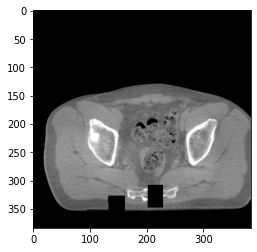

In [29]:
plt.imshow(x.squeeze(), 'gray'),

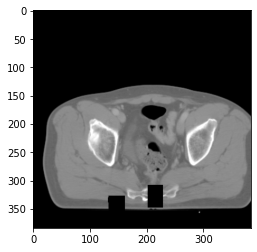

In [30]:
plt.imshow(y.squeeze(), 'gray')

In [31]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# training

In [32]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [33]:
import segmentation_models_pytorch as smp
import torchvision.models as models

model = smp.Unet(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 decoder_attention_type=DECODER_ATT)

replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)

In [34]:
tf_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
replace_relu_to_leakyReLU(tf_discriminator)
replace_bn_to_instanceNorm(tf_discriminator)

In [35]:
edge_discriminator = Discriminator(in_channel=E_IN_CHANNELS, n_classes=E_N_CLASSES, activation=E_ACT)
replace_relu_to_leakyReLU(edge_discriminator)
replace_bn_to_instanceNorm(edge_discriminator)

In [36]:
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): LeakyReLU(negative_slope=0.01)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (relu): LeakyReLU(negative_slope=0.

In [37]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
gen_optimizer = Optimizer(model.parameters(), name=GEN_OPTIM_NAME, lr=GEN_init_lr)
tf_dis_optimizer = Optimizer(tf_discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)
edge_dis_optimizer = Optimizer(edge_discriminator.parameters(), name=E_OPTIM_NAME, lr=E_init_lr)

In [38]:
from codes.scheduler import Scheduler
tf_scheduler = Scheduler(tf_dis_optimizer, name=DIS_scheduler, T_0=10, T_mult=2, eta_min=3e-4)
edge_scheduler = Scheduler(edge_dis_optimizer, name=E_scheduler, T_0=10, T_mult=2, eta_min=3e-4)

In [39]:
import wandb

wandb.init(project="cbct_gan", config={
    "data": {
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "in_channels": GEN_IN_CHANNELS,
        "out_channels": GEN_N_CLASSES,
        "optimizer": GEN_OPTIM_NAME,
        "init_lr": GEN_init_lr,
        "momentum": GEN_momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": GEN_ACT,
        "decoder_attention_type": DECODER_ATT
    },
    "discriminator": {
        "in_channels": DIS_IN_CHANNELS,
        "out_channels": DIS_N_CLASSES,
        "optimizer": DIS_OPTIM_NAME,
        "init_lr": DIS_init_lr,
        "momentum": DIS_momentum,
        "encoder": "resnet34"
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [40]:
wandb.watch(model)
wandb.watch(tf_discriminator)
wandb.watch(edge_discriminator)

max_score = 0

for epoch in range(EPOCH):
        
        loss_air, loss_bone, loss_edge_gen, loss_tf_gen, loss_edge_dis, loss_tf_dis, tf_lr, edge_lr = train_a2b_epoch(epoch, model, gen_optimizer, 
                                                                                             tf_discriminator, tf_dis_optimizer, tf_scheduler, 
                                                                                             edge_discriminator, edge_dis_optimizer, edge_scheduler,
                                                                                             trainloader, device)
        
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, \
            score_air_train, score_bone_train, score_cont_train, score_tf_acc_train, score_edge_acc_train = eval_epoch(model, tf_discriminator, edge_discriminator, trainloader, device)
        
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, \
            score_air_test, score_bone_test, score_cont_test, score_tf_acc_test, score_edge_acc_test = eval_epoch(model, tf_discriminator, edge_discriminator, testloader, device)

        wandb.log({
            "lr scheduler tf": tf_lr,
            "lr scheduler edge": edge_lr,
            
            "loss mask": loss_air,
            "loss bone": loss_bone,
            "loss gen": loss_tf_gen,
            "loss dis": loss_tf_dis,
            "loss edge gen": loss_edge_gen,
            "loss edge dis": loss_edge_dis,
            
            "trainset cont score": score_cont_train,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "trainset acc score": score_tf_acc_train,
            "trainset edge acc score": score_edge_acc_train,
            
            "testset cont score": score_cont_test,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
            "testset acc score": score_tf_acc_test,
            "testset edge acc score": score_edge_acc_test
        })
        
        
        if score_air_test +  score_bone_test + score_cont_test >= max_score:
            max_score = score_air_test +  score_bone_test + score_cont_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": gen_optimizer.state_dict(),
                "tf_discriminator": tf_discriminator.state_dict(),
                "tf_dis_optimizer": tf_dis_optimizer.state_dict(),
                "tf_scheduler": tf_scheduler.state_dict(),
                "edge_discriminator": edge_discriminator.state_dict(),
                "edge_dis_optimizer": edge_dis_optimizer.state_dict(),
                "edge_scheduler": edge_scheduler.state_dict()
            }
            torch.save(checkpoint, os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

168it [01:15,  2.22it/s]
168it [02:31,  1.11it/s]
168it [00:58,  2.87it/s]
24it [00:08,  2.97it/s]
168it [01:14,  2.26it/s]
168it [02:35,  1.08it/s]
168it [00:52,  3.19it/s]
24it [00:08,  2.73it/s]
168it [01:19,  2.13it/s]
168it [02:39,  1.05it/s]
168it [00:52,  3.21it/s]
24it [00:08,  2.91it/s]
168it [01:09,  2.41it/s]
168it [02:42,  1.03it/s]
168it [00:52,  3.19it/s]
24it [00:07,  3.04it/s]
168it [01:11,  2.35it/s]
168it [02:34,  1.08it/s]
168it [00:53,  3.17it/s]
24it [00:07,  3.06it/s]
168it [01:13,  2.30it/s]
168it [02:31,  1.11it/s]
168it [00:58,  2.86it/s]
24it [00:08,  2.70it/s]
168it [01:12,  2.31it/s]
168it [02:36,  1.07it/s]
168it [00:51,  3.24it/s]
24it [00:08,  2.99it/s]
168it [01:20,  2.08it/s]
168it [02:39,  1.05it/s]
168it [00:52,  3.20it/s]
24it [00:07,  3.09it/s]
168it [01:10,  2.38it/s]
168it [02:41,  1.04it/s]
168it [00:52,  3.21it/s]
24it [00:07,  3.06it/s]
168it [01:12,  2.32it/s]
168it [02:34,  1.09it/s]
168it [00:52,  3.19it/s]
24it [00:07,  3.05it/s]
168it [01:

In [41]:
checkpoint = torch.load(os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

In [42]:
model = smp.Unet(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 decoder_attention_type=DECODER_ATT)
replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [43]:
os.mkdir(os.path.join("eval-gan", wandb.run.name))

0it [00:00, ?it/s]

ssim score = 0.8767703175544739
psnr score = 25.91008186340332
snr score = 15.97301959991455
mae error = 0.01783272624015808
air dice score = 0.9966540088114405
bone dice score = 0.9082367679312835
contour dice score = 0.739546000957489


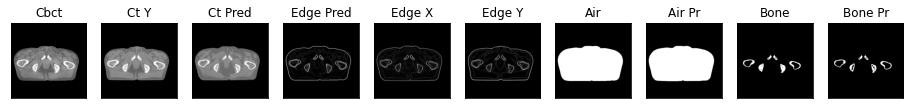

1it [00:00,  1.34it/s]

ssim score = 0.8776977062225342
psnr score = 25.795745849609375
snr score = 15.906220436096191
mae error = 0.017960090190172195
air dice score = 0.9966855596305118
bone dice score = 0.9092885989451803
contour dice score = 0.7289048433303833


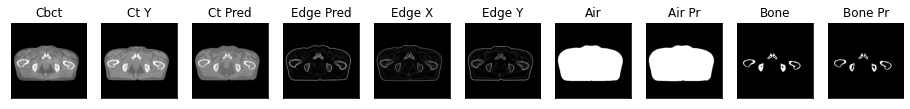

2it [00:01,  1.50it/s]

ssim score = 0.87406986951828
psnr score = 25.280439376831055
snr score = 15.55380916595459
mae error = 0.01976590044796467
air dice score = 0.9967137854249059
bone dice score = 0.8842469398631686
contour dice score = 0.6974235773086548


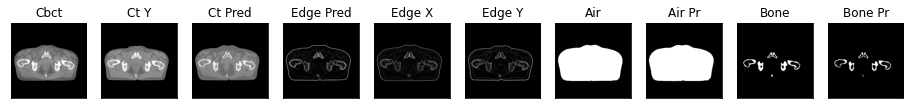

3it [00:01,  1.64it/s]

ssim score = 0.8738221526145935
psnr score = 25.069971084594727
snr score = 15.432592391967773
mae error = 0.02082330733537674
air dice score = 0.9963735000147455
bone dice score = 0.8471400394496161
contour dice score = 0.741141140460968


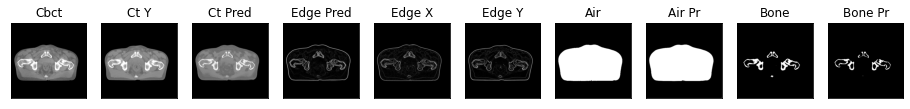

4it [00:02,  1.75it/s]

ssim score = 0.8704193830490112
psnr score = 24.973878860473633
snr score = 15.376801490783691
mae error = 0.0214160718023777
air dice score = 0.9961948699749648
bone dice score = 0.8076526520814794
contour dice score = 0.7376654744148254


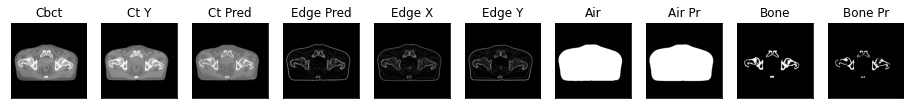

5it [00:02,  1.83it/s]

ssim score = 0.8672834634780884
psnr score = 24.455120086669922
snr score = 14.99458122253418
mae error = 0.023556802421808243
air dice score = 0.9961388432370393
bone dice score = 0.7559294546953584
contour dice score = 0.7543753981590271


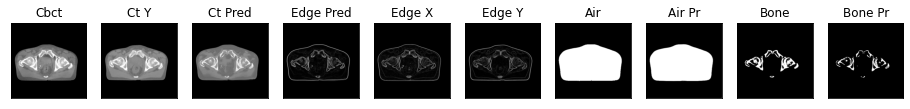

6it [00:03,  1.90it/s]

ssim score = 0.8658468723297119
psnr score = 24.273487091064453
snr score = 14.788887023925781
mae error = 0.023694416508078575
air dice score = 0.9955587421083074
bone dice score = 0.7283386327530967
contour dice score = 0.7949183583259583


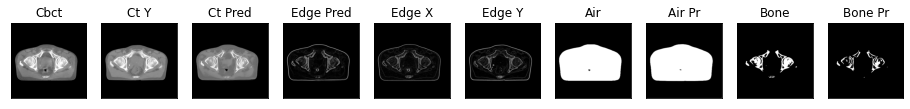

7it [00:03,  1.98it/s]

ssim score = 0.8683301210403442
psnr score = 24.995697021484375
snr score = 15.325563430786133
mae error = 0.021226942539215088
air dice score = 0.9959637438028985
bone dice score = 0.7826912928782829
contour dice score = 0.7710989713668823


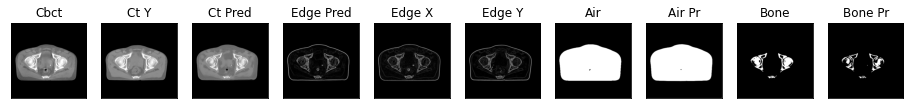

8it [00:04,  2.01it/s]

ssim score = 0.8697094321250916
psnr score = 25.37895965576172
snr score = 15.614270210266113
mae error = 0.020286669954657555
air dice score = 0.9963619506394337
bone dice score = 0.832928713310164
contour dice score = 0.786845326423645


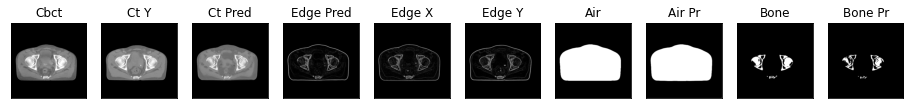

9it [00:04,  1.71it/s]

ssim score = 0.8702427744865417
psnr score = 25.30905532836914
snr score = 15.529083251953125
mae error = 0.020649516955018044
air dice score = 0.9966416736843208
bone dice score = 0.8367323424376456
contour dice score = 0.7623701691627502


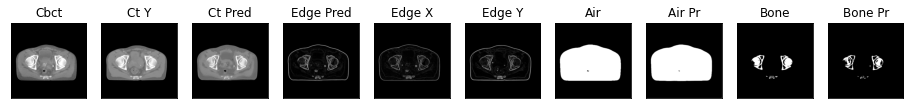

10it [00:05,  1.80it/s]

ssim score = 0.8745406866073608
psnr score = 25.421903610229492
snr score = 15.674200057983398
mae error = 0.020627299323678017
air dice score = 0.9968557953408635
bone dice score = 0.8868079129124802
contour dice score = 0.7371638417243958


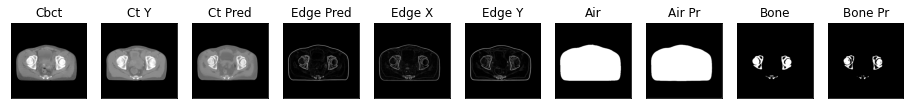

11it [00:05,  1.88it/s]

ssim score = 0.8723324537277222
psnr score = 24.378021240234375
snr score = 14.654026985168457
mae error = 0.022510690614581108
air dice score = 0.9955866278949911
bone dice score = 0.8537997587472399
contour dice score = 0.7524510025978088


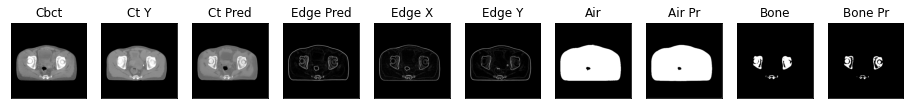

12it [00:06,  1.93it/s]

ssim score = 0.8770861029624939
psnr score = 23.91787338256836
snr score = 14.161958694458008
mae error = 0.022942084819078445
air dice score = 0.9957554204428173
bone dice score = 0.9026351602139968
contour dice score = 0.7484662532806396


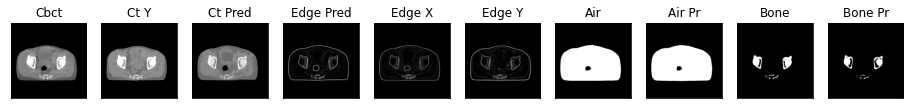

13it [00:06,  2.01it/s]

ssim score = 0.8751437664031982
psnr score = 23.865421295166016
snr score = 13.967547416687012
mae error = 0.022414788603782654
air dice score = 0.9953947091727348
bone dice score = 0.8534302081898361
contour dice score = 0.7041383385658264


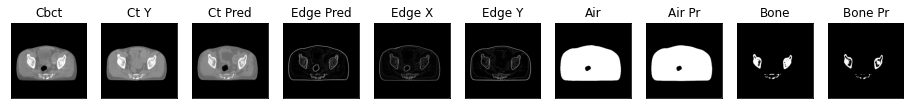

14it [00:07,  2.03it/s]

ssim score = 0.8737247586250305
psnr score = 23.97934341430664
snr score = 13.995810508728027
mae error = 0.022075781598687172
air dice score = 0.9945160029163511
bone dice score = 0.8592353888990883
contour dice score = 0.6893143653869629


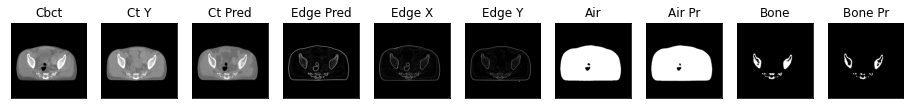

15it [00:07,  2.06it/s]

ssim score = 0.8693060278892517
psnr score = 23.80081558227539
snr score = 13.840768814086914
mae error = 0.022906968370079994
air dice score = 0.9941219613303776
bone dice score = 0.8723079060737486
contour dice score = 0.7075766921043396


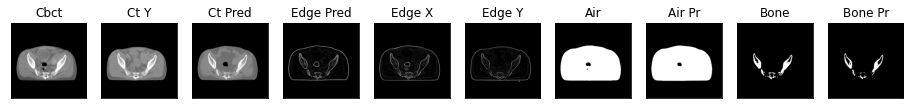

16it [00:08,  2.04it/s]

ssim score = 0.8645780086517334
psnr score = 22.915328979492188
snr score = 12.952738761901855
mae error = 0.02457975409924984
air dice score = 0.9935468605476634
bone dice score = 0.858058485781038
contour dice score = 0.6889168620109558


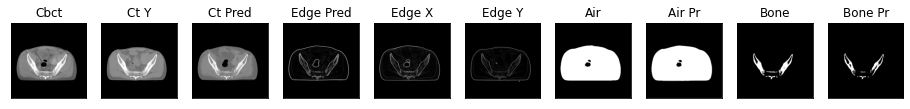

17it [00:08,  2.06it/s]

ssim score = 0.8595338463783264
psnr score = 22.597579956054688
snr score = 12.53322982788086
mae error = 0.02511022426187992
air dice score = 0.9924643849895842
bone dice score = 0.8090985207952959
contour dice score = 0.6430788040161133


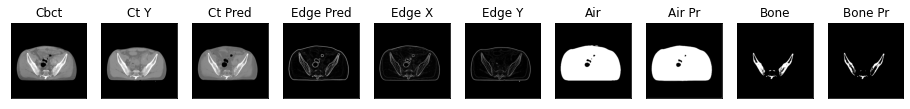

18it [00:09,  2.06it/s]

ssim score = 0.8556793928146362
psnr score = 22.504379272460938
snr score = 12.389345169067383
mae error = 0.02577991969883442
air dice score = 0.9906656331539344
bone dice score = 0.8122594832351256
contour dice score = 0.6045918464660645


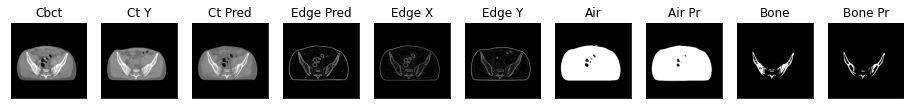

19it [00:09,  1.74it/s]

ssim score = 0.8577290177345276
psnr score = 22.53758430480957
snr score = 12.410240173339844
mae error = 0.026019655168056488
air dice score = 0.9920457670939083
bone dice score = 0.8370535714308447
contour dice score = 0.6002538204193115


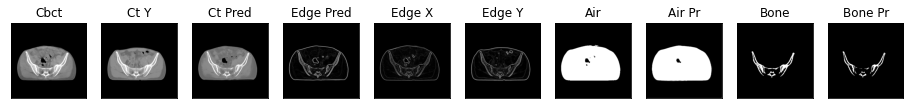

20it [00:10,  1.83it/s]

ssim score = 0.8545272350311279
psnr score = 22.411911010742188
snr score = 12.219720840454102
mae error = 0.026104290038347244
air dice score = 0.9933399303972766
bone dice score = 0.8458781362030185
contour dice score = 0.5124920010566711


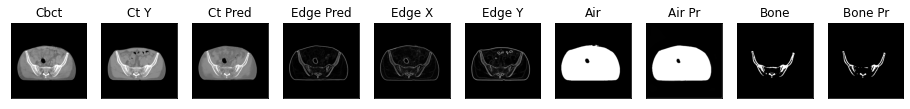

21it [00:10,  1.92it/s]

ssim score = 0.8550761342048645
psnr score = 22.52465057373047
snr score = 12.273027420043945
mae error = 0.02593817748129368
air dice score = 0.9917272219116917
bone dice score = 0.8611840186663577
contour dice score = 0.5077519416809082


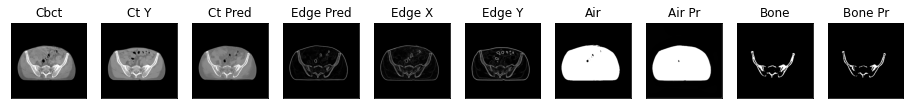

22it [00:11,  1.99it/s]

ssim score = 0.8589280843734741
psnr score = 22.61052131652832
snr score = 12.32547378540039
mae error = 0.025611503049731255
air dice score = 0.991746749576041
bone dice score = 0.8594587168586418
contour dice score = 0.48114433884620667


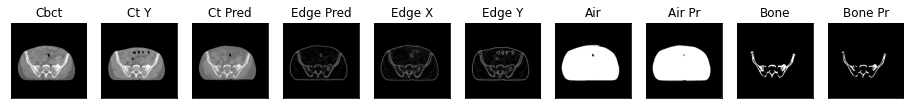

23it [00:11,  2.02it/s]

ssim score = 0.8590028882026672
psnr score = 22.568439483642578
snr score = 12.234827041625977
mae error = 0.025502890348434448
air dice score = 0.9914481120765543
bone dice score = 0.8381106176848592
contour dice score = 0.5185185074806213


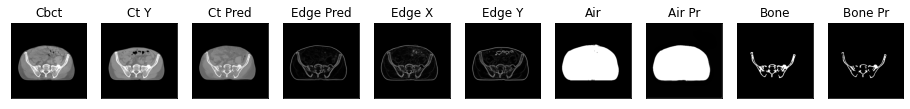

24it [00:12,  2.05it/s]

ssim score = 0.8594483137130737
psnr score = 22.42617416381836
snr score = 11.995558738708496
mae error = 0.025540465489029884
air dice score = 0.9922338649851722
bone dice score = 0.8266318537881641
contour dice score = 0.4976525902748108


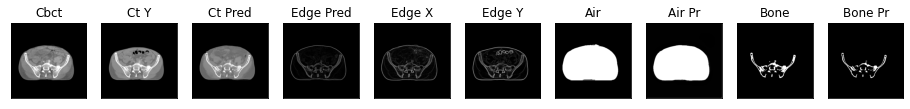

25it [00:12,  2.09it/s]

ssim score = 0.8594369888305664
psnr score = 22.516559600830078
snr score = 12.003211975097656
mae error = 0.025194639340043068
air dice score = 0.9915936538006256
bone dice score = 0.82075962539255
contour dice score = 0.5088195204734802


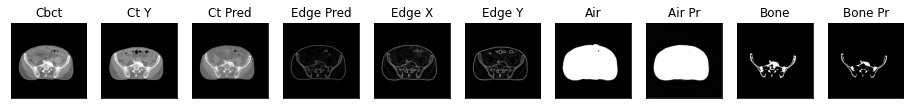

26it [00:13,  2.10it/s]

ssim score = 0.8588703274726868
psnr score = 22.578014373779297
snr score = 11.973482131958008
mae error = 0.0251163337379694
air dice score = 0.990035389465305
bone dice score = 0.8143113618900447
contour dice score = 0.5358385443687439


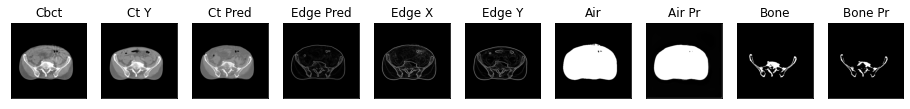

27it [00:13,  2.13it/s]

ssim score = 0.8610652089118958
psnr score = 22.4187068939209
snr score = 11.773066520690918
mae error = 0.025422321632504463
air dice score = 0.9888039155705246
bone dice score = 0.8329116973878699
contour dice score = 0.4883556663990021


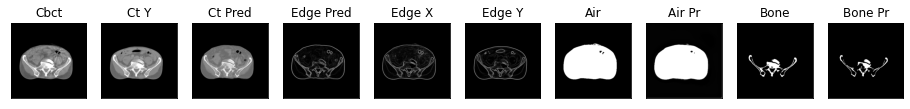

28it [00:14,  2.09it/s]

ssim score = 0.837515652179718
psnr score = 23.468236923217773
snr score = 14.840394973754883
mae error = 0.02475678361952305
air dice score = 0.9959691151247989
bone dice score = 0.9628492477751658
contour dice score = 0.3843204081058502


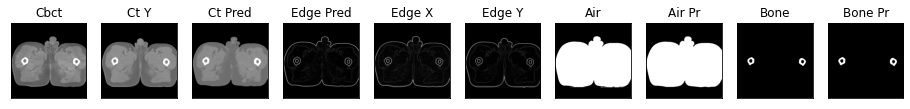

29it [00:14,  1.76it/s]

ssim score = 0.8403688073158264
psnr score = 23.809335708618164
snr score = 15.220748901367188
mae error = 0.02410399354994297
air dice score = 0.995442193145503
bone dice score = 0.9660138248857715
contour dice score = 0.32487308979034424


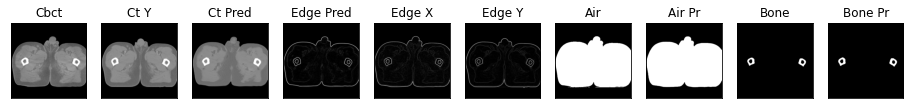

30it [00:15,  1.86it/s]

ssim score = 0.8434752225875854
psnr score = 24.26460075378418
snr score = 15.763463973999023
mae error = 0.023627445101737976
air dice score = 0.9960969609878793
bone dice score = 0.9723884031299497
contour dice score = 0.34341636300086975


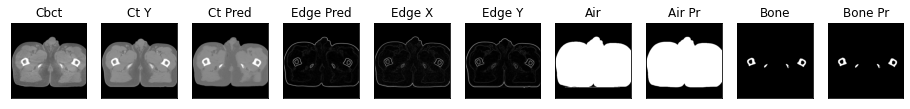

31it [00:15,  1.91it/s]

ssim score = 0.8442805409431458
psnr score = 24.553030014038086
snr score = 16.21445083618164
mae error = 0.024400250986218452
air dice score = 0.997064253503225
bone dice score = 0.970592961594559
contour dice score = 0.374942421913147


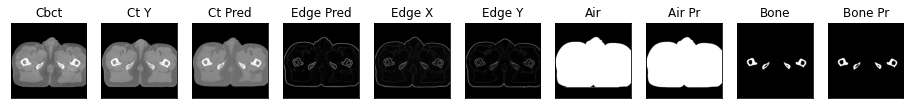

32it [00:16,  1.93it/s]

ssim score = 0.845712423324585
psnr score = 24.730186462402344
snr score = 16.519752502441406
mae error = 0.024499166756868362
air dice score = 0.9971193713238856
bone dice score = 0.9597173144882019
contour dice score = 0.37953487038612366


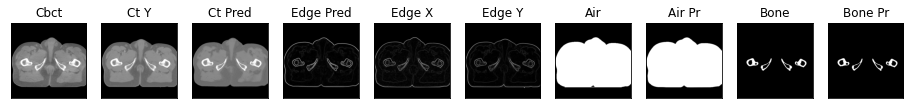

33it [00:16,  2.01it/s]

ssim score = 0.8459453582763672
psnr score = 24.958805084228516
snr score = 16.851608276367188
mae error = 0.024785472080111504
air dice score = 0.9974130738804508
bone dice score = 0.9449231922075069
contour dice score = 0.38619402050971985


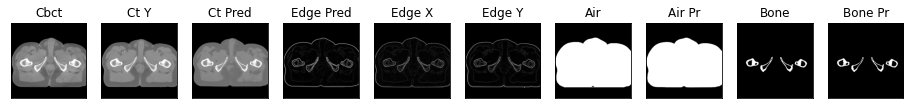

34it [00:17,  2.04it/s]

ssim score = 0.8474506735801697
psnr score = 25.221324920654297
snr score = 17.181228637695312
mae error = 0.025097638368606567
air dice score = 0.9968846234340916
bone dice score = 0.9222858478447786
contour dice score = 0.3748837113380432


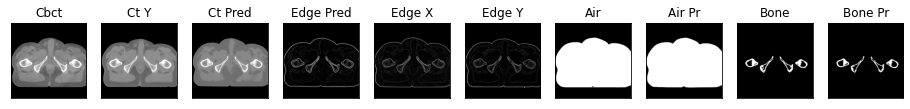

35it [00:17,  2.08it/s]

ssim score = 0.8444905877113342
psnr score = 25.360946655273438
snr score = 17.310958862304688
mae error = 0.024523399770259857
air dice score = 0.9971142380157423
bone dice score = 0.9253566294379592
contour dice score = 0.37198516726493835


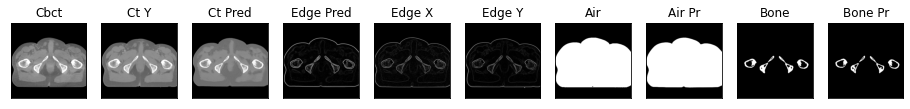

36it [00:18,  2.10it/s]

ssim score = 0.8467391729354858
psnr score = 25.459590911865234
snr score = 17.395938873291016
mae error = 0.024408292025327682
air dice score = 0.9968347275604812
bone dice score = 0.9269896952430718
contour dice score = 0.3730858564376831


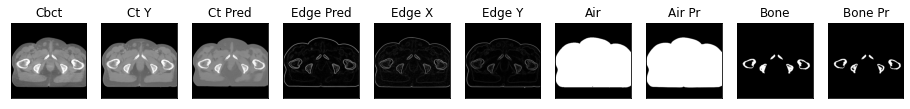

37it [00:18,  2.12it/s]

ssim score = 0.8509648442268372
psnr score = 25.792491912841797
snr score = 17.740840911865234
mae error = 0.023767750710248947
air dice score = 0.9970772045719192
bone dice score = 0.9134649071597165
contour dice score = 0.3986988961696625


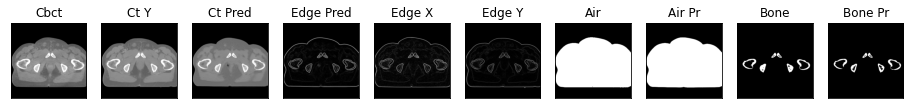

38it [00:19,  2.11it/s]

ssim score = 0.8552783131599426
psnr score = 25.873498916625977
snr score = 17.860933303833008
mae error = 0.02382352203130722
air dice score = 0.997131709750407
bone dice score = 0.930973451328248
contour dice score = 0.385261207818985


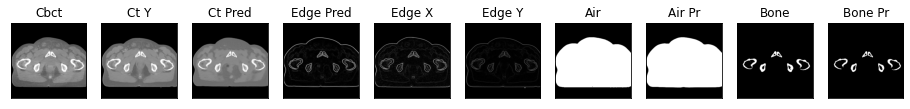

39it [00:20,  1.72it/s]

ssim score = 0.849614679813385
psnr score = 25.542720794677734
snr score = 17.671443939208984
mae error = 0.02538565918803215
air dice score = 0.9970842018373702
bone dice score = 0.906804123712301
contour dice score = 0.39457690715789795


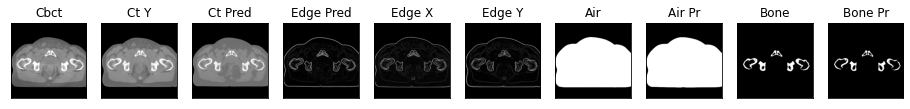

40it [00:20,  1.80it/s]

ssim score = 0.8499232530593872
psnr score = 25.295228958129883
snr score = 17.518638610839844
mae error = 0.027046065777540207
air dice score = 0.9966702342728049
bone dice score = 0.873686997970927
contour dice score = 0.40112465620040894


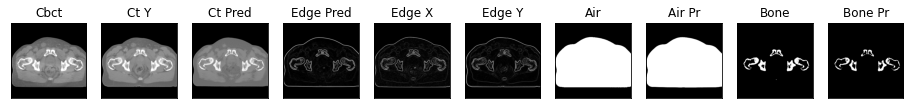

41it [00:21,  1.90it/s]

ssim score = 0.8394263386726379
psnr score = 24.565948486328125
snr score = 16.755313873291016
mae error = 0.028444034978747368
air dice score = 0.9967264336014616
bone dice score = 0.8228051391878765
contour dice score = 0.43233081698417664


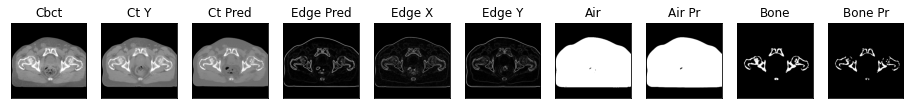

42it [00:21,  1.95it/s]

ssim score = 0.8369290828704834
psnr score = 23.58543586730957
snr score = 15.8469877243042
mae error = 0.031199773773550987
air dice score = 0.9962135531992797
bone dice score = 0.7519292604521549
contour dice score = 0.36928874254226685


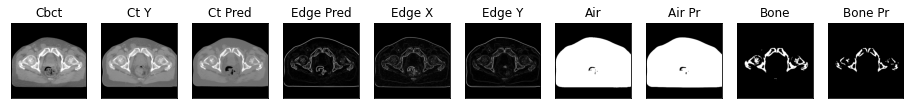

43it [00:22,  1.95it/s]

ssim score = 0.8379403352737427
psnr score = 23.834516525268555
snr score = 15.959970474243164
mae error = 0.02933392859995365
air dice score = 0.9965318754365282
bone dice score = 0.8076617705457754
contour dice score = 0.40548205375671387


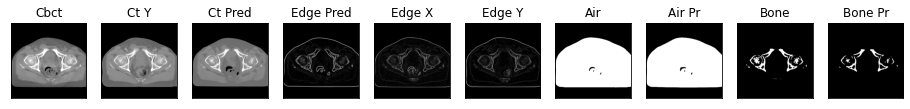

44it [00:22,  1.94it/s]

ssim score = 0.8449867963790894
psnr score = 24.26416015625
snr score = 16.21105194091797
mae error = 0.027003755792975426
air dice score = 0.9966307196251545
bone dice score = 0.83035714285899
contour dice score = 0.44381222128868103


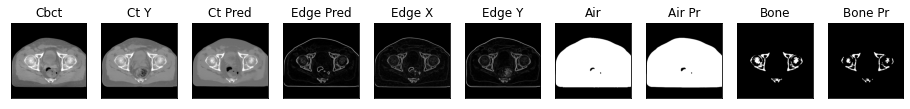

45it [00:22,  2.03it/s]

ssim score = 0.8407621383666992
psnr score = 24.55695343017578
snr score = 16.413257598876953
mae error = 0.026632478460669518
air dice score = 0.9967763981541421
bone dice score = 0.8455402465573417
contour dice score = 0.41904762387275696


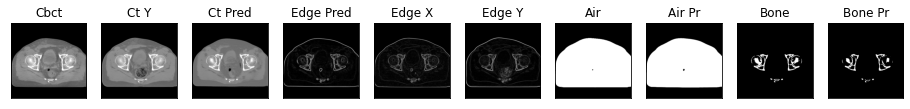

46it [00:23,  2.13it/s]

ssim score = 0.8406920433044434
psnr score = 24.492935180664062
snr score = 16.364931106567383
mae error = 0.027234401553869247
air dice score = 0.9969632922770467
bone dice score = 0.8499153020909099
contour dice score = 0.4043872058391571


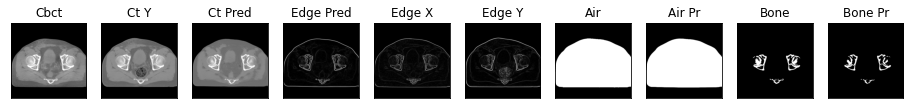

47it [00:23,  2.17it/s]

ssim score = 0.8324382901191711
psnr score = 24.39421844482422
snr score = 16.276248931884766
mae error = 0.027613544836640358
air dice score = 0.9969230769230788
bone dice score = 0.8323303589973818
contour dice score = 0.3977055549621582


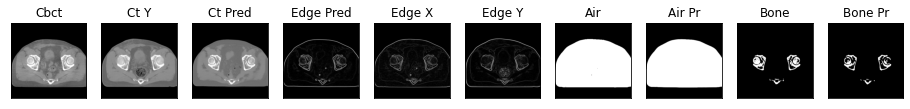

48it [00:24,  2.18it/s]

ssim score = 0.8391797542572021
psnr score = 24.53185272216797
snr score = 16.475473403930664
mae error = 0.02730872668325901
air dice score = 0.9970108662362659
bone dice score = 0.8467725718897369
contour dice score = 0.42522695660591125


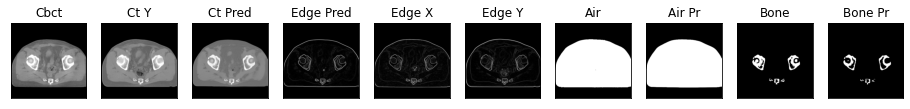

49it [00:24,  1.93it/s]

ssim score = 0.8404639363288879
psnr score = 25.028467178344727
snr score = 17.04216766357422
mae error = 0.02687872014939785
air dice score = 0.9966912419199412
bone dice score = 0.9049137284329997
contour dice score = 0.4051477611064911


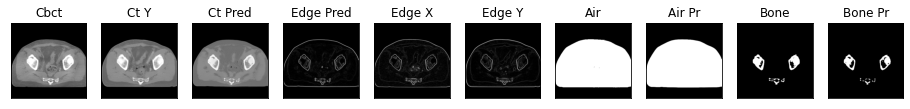

50it [00:25,  1.93it/s]

ssim score = 0.8495588302612305
psnr score = 25.137439727783203
snr score = 17.03203582763672
mae error = 0.026038633659482002
air dice score = 0.9968022881132292
bone dice score = 0.8800763439732788
contour dice score = 0.4005722403526306


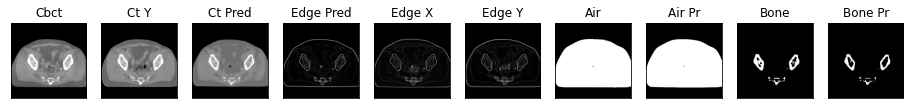

51it [00:25,  1.95it/s]

ssim score = 0.8441076278686523
psnr score = 24.475494384765625
snr score = 16.451717376708984
mae error = 0.02779032476246357
air dice score = 0.9967236449756441
bone dice score = 0.8748027842238998
contour dice score = 0.3761996030807495


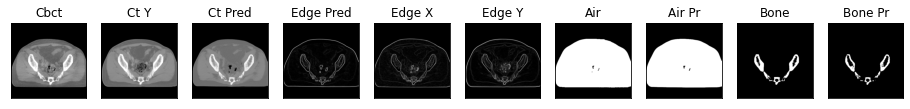

52it [00:26,  2.02it/s]

ssim score = 0.843380868434906
psnr score = 24.423614501953125
snr score = 16.479984283447266
mae error = 0.028962144628167152
air dice score = 0.99583943529066
bone dice score = 0.8300331366699262
contour dice score = 0.2877767086029053


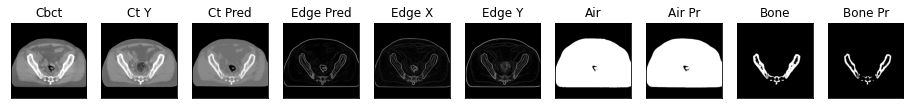

53it [00:26,  2.07it/s]

ssim score = 0.8278620839118958
psnr score = 23.910316467285156
snr score = 15.98824405670166
mae error = 0.030516773462295532
air dice score = 0.9959352326697295
bone dice score = 0.8214256552639714
contour dice score = 0.3281853199005127


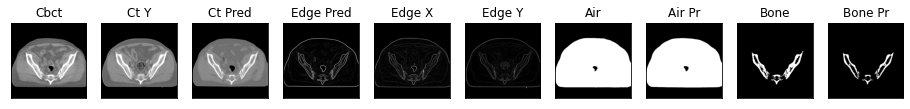

54it [00:27,  2.09it/s]

ssim score = 0.8390807509422302
psnr score = 24.71889877319336
snr score = 16.80936622619629
mae error = 0.02848951704800129
air dice score = 0.996248052806083
bone dice score = 0.8416164249646275
contour dice score = 0.32723772525787354


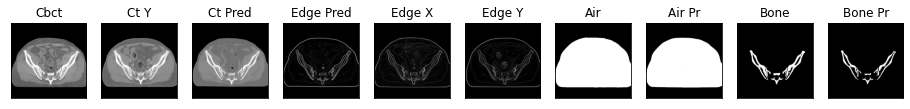

55it [00:27,  2.06it/s]

ssim score = 0.8058798313140869
psnr score = 20.996000289916992
snr score = 10.876211166381836
mae error = 0.030871577560901642
air dice score = 0.9965613084844844
bone dice score = 0.955549640671931
contour dice score = 0.6021029353141785


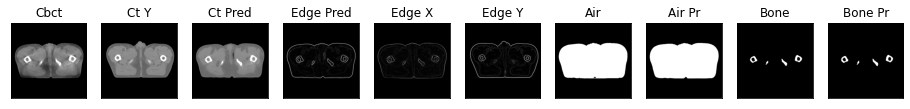

56it [00:28,  2.09it/s]

ssim score = 0.7958436012268066
psnr score = 20.639392852783203
snr score = 10.732582092285156
mae error = 0.03307574987411499
air dice score = 0.996679094234025
bone dice score = 0.9411262798647371
contour dice score = 0.634361207485199


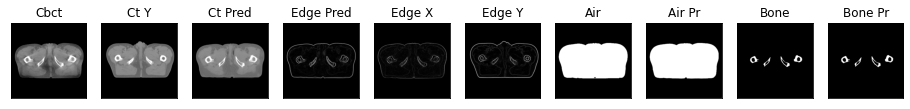

57it [00:28,  2.13it/s]

ssim score = 0.7910639643669128
psnr score = 20.622968673706055
snr score = 10.847296714782715
mae error = 0.033564917743206024
air dice score = 0.9963184780694061
bone dice score = 0.9223615042474249
contour dice score = 0.6252747178077698


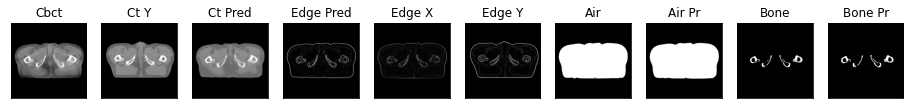

58it [00:29,  2.21it/s]

ssim score = 0.7902047634124756
psnr score = 20.795316696166992
snr score = 11.090045928955078
mae error = 0.03323354572057724
air dice score = 0.9966414409358395
bone dice score = 0.9265426052903714
contour dice score = 0.5523287653923035


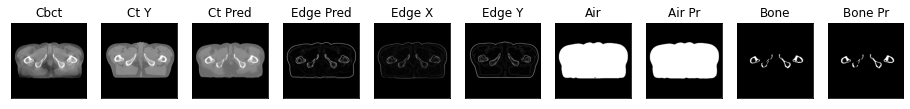

59it [00:29,  1.92it/s]

ssim score = 0.7869205474853516
psnr score = 20.769012451171875
snr score = 11.111308097839355
mae error = 0.03359838202595711
air dice score = 0.9957155847789629
bone dice score = 0.9087726123340056
contour dice score = 0.5602179765701294


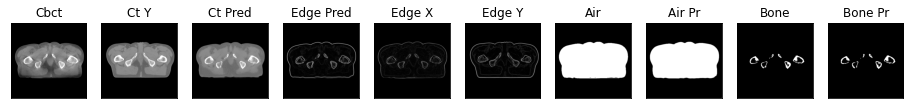

60it [00:30,  2.10it/s]

ssim score = 0.7879254221916199
psnr score = 20.82386016845703
snr score = 11.171771049499512
mae error = 0.03335331752896309
air dice score = 0.9953102390209075
bone dice score = 0.919735599623801
contour dice score = 0.5095541477203369


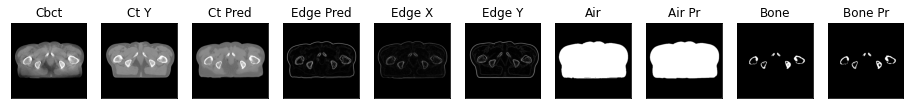

61it [00:30,  2.20it/s]

ssim score = 0.7859963774681091
psnr score = 20.822227478027344
snr score = 11.163636207580566
mae error = 0.03347435221076012
air dice score = 0.995290069171682
bone dice score = 0.9245210727983808
contour dice score = 0.5324813723564148


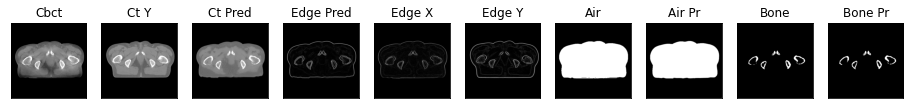

62it [00:31,  1.88it/s]

ssim score = 0.7866597771644592
psnr score = 20.749267578125
snr score = 11.104788780212402
mae error = 0.033394262194633484
air dice score = 0.9953838026034354
bone dice score = 0.9278234854164581
contour dice score = 0.5039872527122498


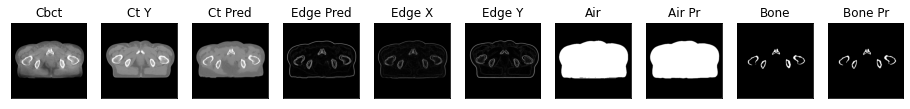

63it [00:31,  1.78it/s]

ssim score = 0.7856288552284241
psnr score = 20.65678596496582
snr score = 11.070313453674316
mae error = 0.03426903113722801
air dice score = 0.9954156214860346
bone dice score = 0.9104781281805616
contour dice score = 0.5344735383987427


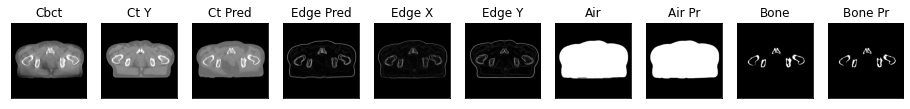

64it [00:32,  1.92it/s]

ssim score = 0.7752925157546997
psnr score = 20.448028564453125
snr score = 10.960113525390625
mae error = 0.03599904850125313
air dice score = 0.9954282756836061
bone dice score = 0.8832188420038728
contour dice score = 0.5071315169334412


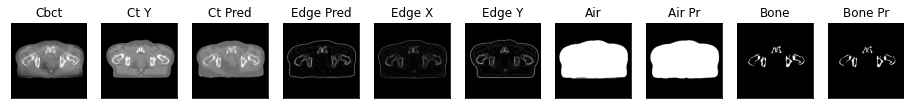

65it [00:32,  2.02it/s]

ssim score = 0.7663917541503906
psnr score = 20.270307540893555
snr score = 10.818222045898438
mae error = 0.037700068205595016
air dice score = 0.9959350993833788
bone dice score = 0.8806390977462306
contour dice score = 0.5096566677093506


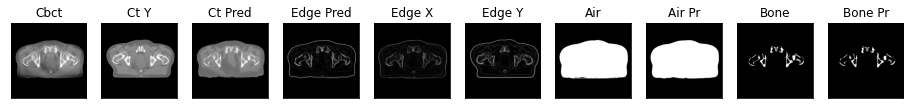

66it [00:33,  2.07it/s]

ssim score = 0.7581520080566406
psnr score = 20.17188262939453
snr score = 10.7525053024292
mae error = 0.03850345313549042
air dice score = 0.9961557315720253
bone dice score = 0.8378574539143873
contour dice score = 0.549839198589325


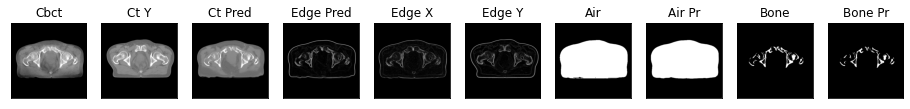

67it [00:33,  2.17it/s]

ssim score = 0.7607171535491943
psnr score = 20.28636932373047
snr score = 10.983809471130371
mae error = 0.03803906962275505
air dice score = 0.9963969696709148
bone dice score = 0.8611544461798163
contour dice score = 0.5871171951293945


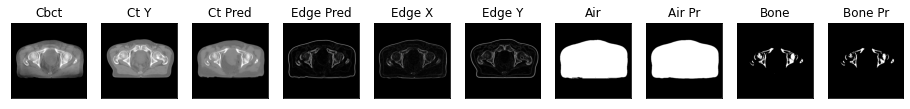

68it [00:34,  2.22it/s]

ssim score = 0.7627847194671631
psnr score = 20.3404541015625
snr score = 11.021905899047852
mae error = 0.037775710225105286
air dice score = 0.9968372380837816
bone dice score = 0.8770479252813191
contour dice score = 0.5863760113716125


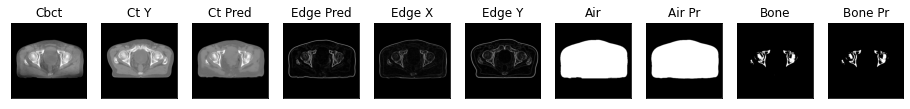

69it [00:34,  1.87it/s]

ssim score = 0.774307906627655
psnr score = 20.865219116210938
snr score = 11.347508430480957
mae error = 0.03476959466934204
air dice score = 0.9968654191321102
bone dice score = 0.8953732065146643
contour dice score = 0.6176154613494873


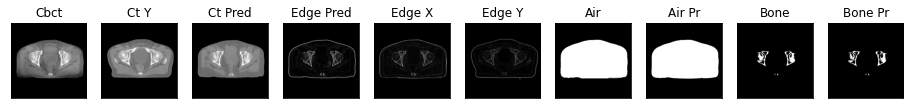

70it [00:35,  1.98it/s]

ssim score = 0.7890177369117737
psnr score = 21.60222053527832
snr score = 11.914115905761719
mae error = 0.03143993392586708
air dice score = 0.9965617470783454
bone dice score = 0.910549777118714
contour dice score = 0.5758880376815796


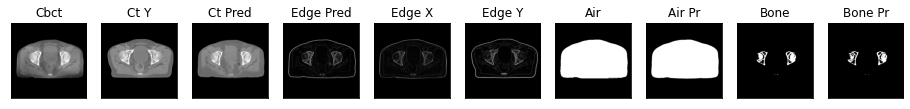

71it [00:35,  2.09it/s]

ssim score = 0.7981150150299072
psnr score = 22.017953872680664
snr score = 12.344017028808594
mae error = 0.029995020478963852
air dice score = 0.9965597507958814
bone dice score = 0.9001851060814441
contour dice score = 0.557517409324646


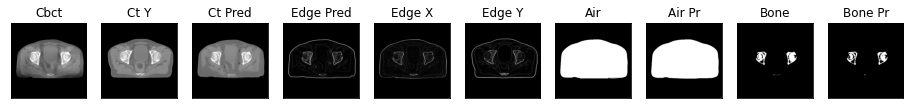

72it [00:36,  2.17it/s]

ssim score = 0.8015305399894714
psnr score = 22.119569778442383
snr score = 12.527463912963867
mae error = 0.030043993145227432
air dice score = 0.9964130156290064
bone dice score = 0.9083019959515721
contour dice score = 0.5442694425582886


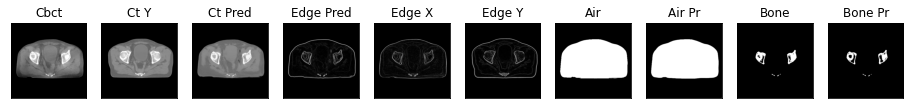

73it [00:36,  2.18it/s]

ssim score = 0.800335705280304
psnr score = 22.089879989624023
snr score = 12.589945793151855
mae error = 0.03003043681383133
air dice score = 0.9965685481467634
bone dice score = 0.919080604535279
contour dice score = 0.5506607890129089


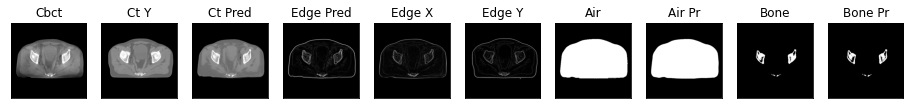

74it [00:36,  2.25it/s]

ssim score = 0.8027454018592834
psnr score = 22.42612075805664
snr score = 12.86275863647461
mae error = 0.02860729955136776
air dice score = 0.9964197845083597
bone dice score = 0.9339945280449043
contour dice score = 0.5528717041015625


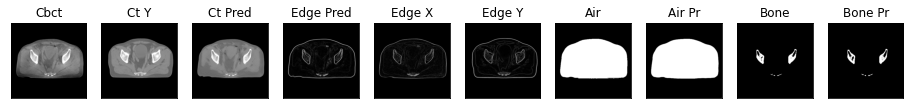

75it [00:37,  2.26it/s]

ssim score = 0.8071873784065247
psnr score = 22.564313888549805
snr score = 12.964558601379395
mae error = 0.027807461097836494
air dice score = 0.9964895024251293
bone dice score = 0.9369701437534653
contour dice score = 0.5181236863136292


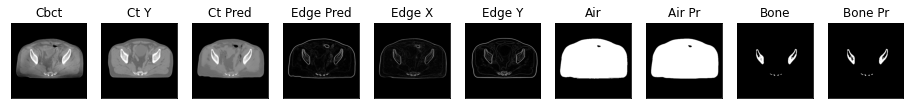

76it [00:37,  2.26it/s]

ssim score = 0.8016764521598816
psnr score = 22.25537872314453
snr score = 12.693368911743164
mae error = 0.02951785922050476
air dice score = 0.9962924312996884
bone dice score = 0.9160863509763912
contour dice score = 0.5374402403831482


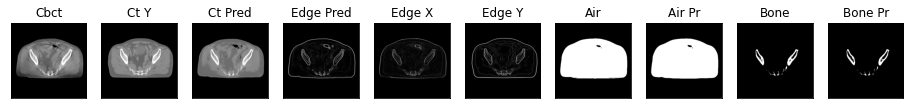

77it [00:38,  2.28it/s]

ssim score = 0.8004081845283508
psnr score = 22.076799392700195
snr score = 12.645294189453125
mae error = 0.030702859163284302
air dice score = 0.9966711391158166
bone dice score = 0.9055623471897072
contour dice score = 0.5735687613487244


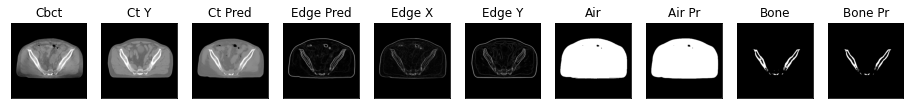

78it [00:38,  2.25it/s]

ssim score = 0.8047826290130615
psnr score = 21.99747085571289
snr score = 12.583714485168457
mae error = 0.031049665063619614
air dice score = 0.996335123156911
bone dice score = 0.8964052287598626
contour dice score = 0.5766541361808777


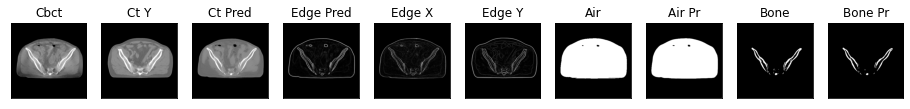

79it [00:39,  1.91it/s]

ssim score = 0.8065914511680603
psnr score = 22.406986236572266
snr score = 12.981962203979492
mae error = 0.030080491676926613
air dice score = 0.996216984200349
bone dice score = 0.9093739190607165
contour dice score = 0.5805405378341675


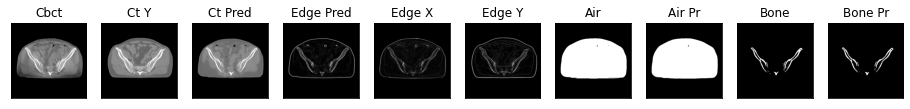

80it [00:39,  1.99it/s]

ssim score = 0.8080315589904785
psnr score = 22.537261962890625
snr score = 13.11149787902832
mae error = 0.029467284679412842
air dice score = 0.9963670093530216
bone dice score = 0.9023084643709884
contour dice score = 0.5627044439315796


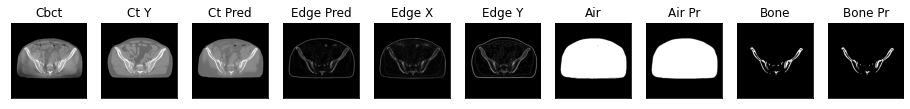

81it [00:40,  2.05it/s]

ssim score = 0.8488330245018005
psnr score = 24.064685821533203
snr score = 14.498820304870605
mae error = 0.020104017108678818
air dice score = 0.9967660225263284
bone dice score = 0.9150976909444015
contour dice score = 0.4584221839904785


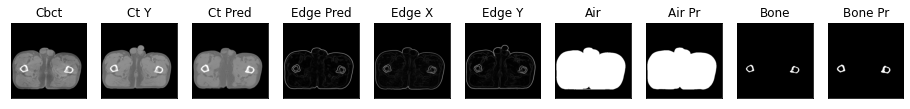

82it [00:40,  2.17it/s]

ssim score = 0.8500664234161377
psnr score = 24.28278923034668
snr score = 14.781314849853516
mae error = 0.02009161002933979
air dice score = 0.9965964856735819
bone dice score = 0.9047005795265711
contour dice score = 0.4018937349319458


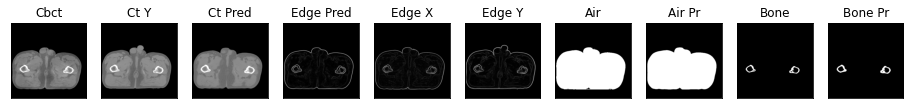

83it [00:41,  2.22it/s]

ssim score = 0.8545761704444885
psnr score = 25.47931480407715
snr score = 16.117053985595703
mae error = 0.019420621916651726
air dice score = 0.9971447122417552
bone dice score = 0.9397697077072682
contour dice score = 0.42711520195007324


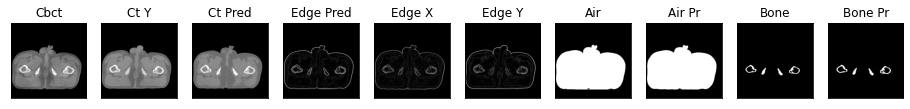

84it [00:41,  2.28it/s]

ssim score = 0.8537747859954834
psnr score = 25.447948455810547
snr score = 16.207178115844727
mae error = 0.020057886838912964
air dice score = 0.9976335045928713
bone dice score = 0.9296545914083898
contour dice score = 0.47343993186950684


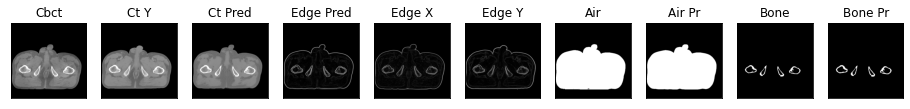

85it [00:42,  2.32it/s]

ssim score = 0.85196453332901
psnr score = 25.297014236450195
snr score = 16.080419540405273
mae error = 0.02075178362429142
air dice score = 0.9978334640502591
bone dice score = 0.9123867069505311
contour dice score = 0.5313959717750549


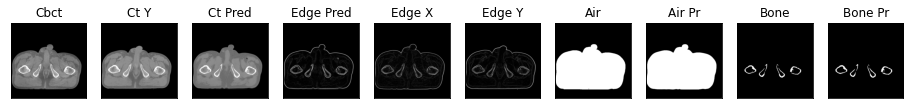

86it [00:42,  2.29it/s]

ssim score = 0.8503508567810059
psnr score = 25.210323333740234
snr score = 15.989331245422363
mae error = 0.020962683483958244
air dice score = 0.9980457238576805
bone dice score = 0.9143541625091963
contour dice score = 0.5243328213691711


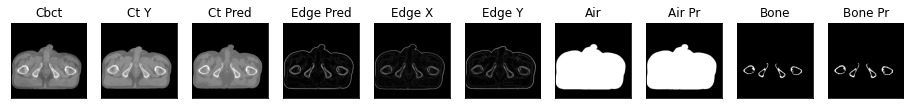

87it [00:42,  2.34it/s]

ssim score = 0.852559506893158
psnr score = 24.903249740600586
snr score = 15.68851089477539
mae error = 0.021226651966571808
air dice score = 0.9978918650793667
bone dice score = 0.9106299212616018
contour dice score = 0.4857744872570038


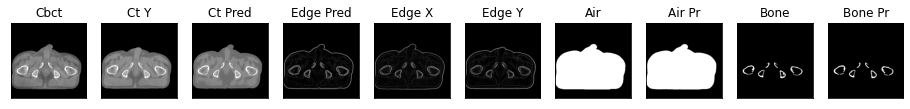

88it [00:43,  2.33it/s]

ssim score = 0.8532453179359436
psnr score = 24.769638061523438
snr score = 15.533343315124512
mae error = 0.021098483353853226
air dice score = 0.997750368474131
bone dice score = 0.9271653543321424
contour dice score = 0.500792384147644


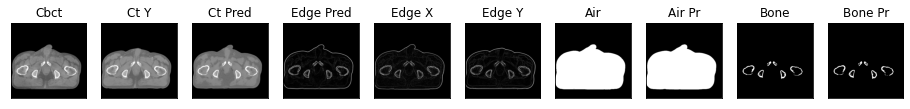

89it [00:43,  1.96it/s]

ssim score = 0.8511547446250916
psnr score = 24.663524627685547
snr score = 15.444137573242188
mae error = 0.021374084055423737
air dice score = 0.9974800895968163
bone dice score = 0.9212980231271671
contour dice score = 0.4824654757976532


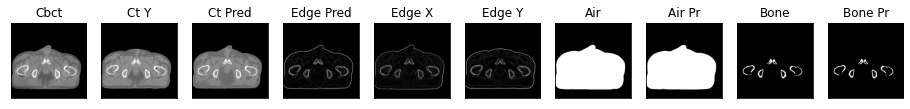

90it [00:44,  2.03it/s]

ssim score = 0.8511343598365784
psnr score = 24.77973747253418
snr score = 15.628946304321289
mae error = 0.021580711007118225
air dice score = 0.9973696739800678
bone dice score = 0.9255048362476581
contour dice score = 0.5018726587295532


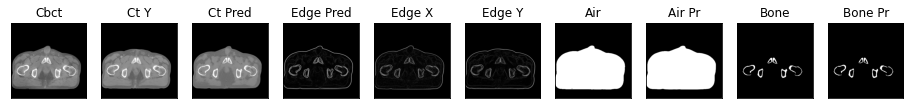

91it [00:44,  2.14it/s]

ssim score = 0.850477397441864
psnr score = 24.778961181640625
snr score = 15.709531784057617
mae error = 0.022606154903769493
air dice score = 0.9978523279510912
bone dice score = 0.9085677749375229
contour dice score = 0.5250134468078613


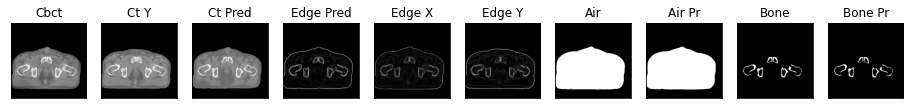

92it [00:45,  2.21it/s]

ssim score = 0.8499573469161987
psnr score = 24.992094039916992
snr score = 15.973363876342773
mae error = 0.022916274145245552
air dice score = 0.9976087093323284
bone dice score = 0.8915588416529334
contour dice score = 0.6095853447914124


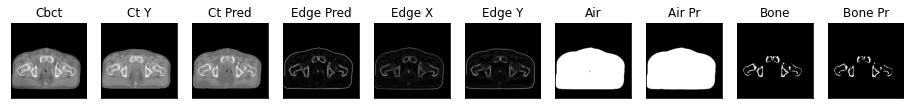

93it [00:45,  2.24it/s]

ssim score = 0.8526698350906372
psnr score = 25.000905990600586
snr score = 16.09844398498535
mae error = 0.023710232228040695
air dice score = 0.998027084188265
bone dice score = 0.8382966051245042
contour dice score = 0.6066810488700867


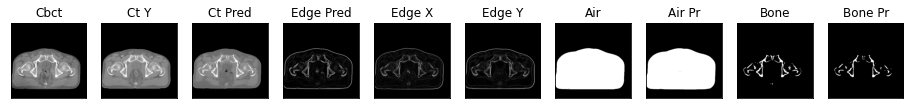

94it [00:46,  2.27it/s]

ssim score = 0.8517856001853943
psnr score = 24.758262634277344
snr score = 15.817564964294434
mae error = 0.023779217153787613
air dice score = 0.9979769451077789
bone dice score = 0.8628421215422477
contour dice score = 0.6274932622909546


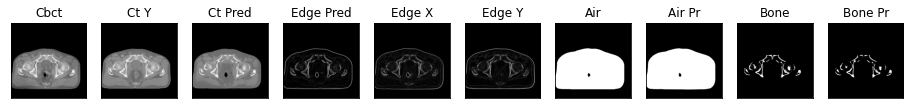

95it [00:46,  2.28it/s]

ssim score = 0.8399003744125366
psnr score = 23.91843605041504
snr score = 14.882068634033203
mae error = 0.024813106283545494
air dice score = 0.9975130942385371
bone dice score = 0.8474477109865811
contour dice score = 0.6024878025054932


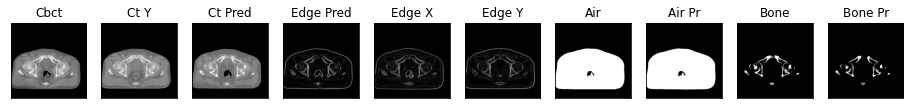

96it [00:46,  2.34it/s]

ssim score = 0.8505806922912598
psnr score = 23.953950881958008
snr score = 14.757823944091797
mae error = 0.02287163771688938
air dice score = 0.9977285541683466
bone dice score = 0.8732443211397044
contour dice score = 0.6203904747962952


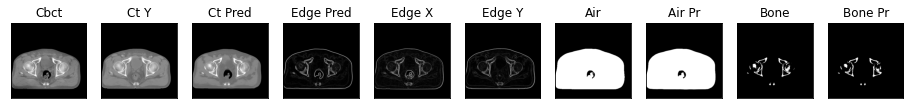

97it [00:47,  2.33it/s]

ssim score = 0.8453614711761475
psnr score = 23.670772552490234
snr score = 14.358223915100098
mae error = 0.023278379812836647
air dice score = 0.9975986780519194
bone dice score = 0.875807860264178
contour dice score = 0.5936819314956665


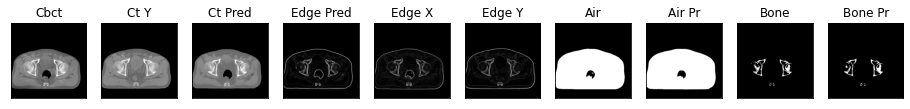

98it [00:47,  2.31it/s]

ssim score = 0.8400920629501343
psnr score = 23.577871322631836
snr score = 14.220227241516113
mae error = 0.023581208661198616
air dice score = 0.9977633400788175
bone dice score = 0.8846409574487261
contour dice score = 0.625545859336853


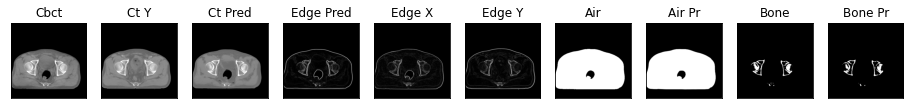

99it [00:48,  1.95it/s]

ssim score = 0.8357404470443726
psnr score = 23.043941497802734
snr score = 13.692971229553223
mae error = 0.025432072579860687
air dice score = 0.9978667191781964
bone dice score = 0.9064844140705703
contour dice score = 0.5773646831512451


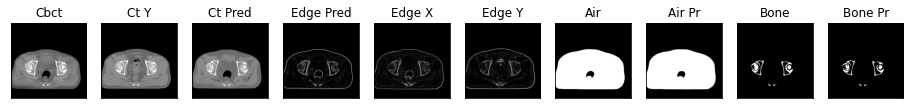

100it [00:48,  2.05it/s]

ssim score = 0.8399275541305542
psnr score = 22.78636932373047
snr score = 13.465499877929688
mae error = 0.02606060542166233
air dice score = 0.9978462803123733
bone dice score = 0.9235154394311399
contour dice score = 0.5767543911933899


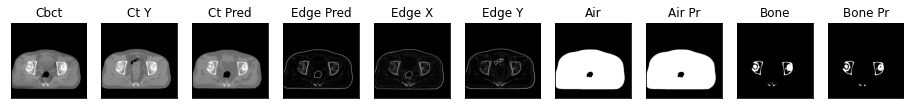

101it [00:49,  2.12it/s]

ssim score = 0.8450296521186829
psnr score = 23.357769012451172
snr score = 13.994316101074219
mae error = 0.02469533681869507
air dice score = 0.9975629969393888
bone dice score = 0.9148409894007978
contour dice score = 0.5609220862388611


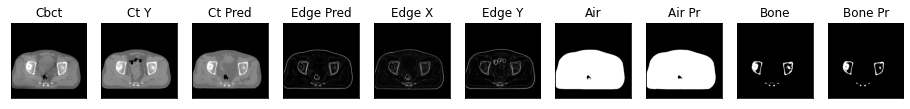

102it [00:49,  2.16it/s]

ssim score = 0.8491845726966858
psnr score = 23.76818084716797
snr score = 14.314523696899414
mae error = 0.022944651544094086
air dice score = 0.9976348428035785
bone dice score = 0.9143523014194144
contour dice score = 0.5435616374015808


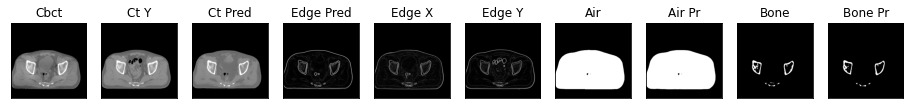

103it [00:50,  2.22it/s]

ssim score = 0.8480244278907776
psnr score = 23.441469192504883
snr score = 13.922085762023926
mae error = 0.023676970973610878
air dice score = 0.9974361535644146
bone dice score = 0.9263620035935669
contour dice score = 0.5951595306396484


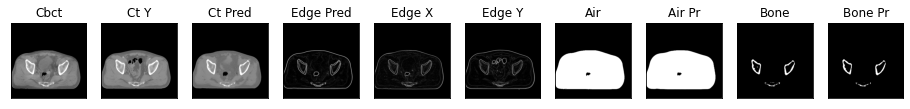

104it [00:50,  2.27it/s]

ssim score = 0.8479346036911011
psnr score = 23.553773880004883
snr score = 14.034088134765625
mae error = 0.023510504513978958
air dice score = 0.9969313322713198
bone dice score = 0.9270371027884424
contour dice score = 0.6119073629379272


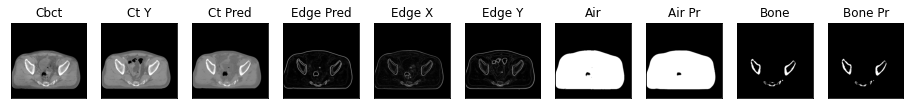

105it [00:51,  2.26it/s]

ssim score = 0.8440487384796143
psnr score = 23.436975479125977
snr score = 13.99345588684082
mae error = 0.02446756884455681
air dice score = 0.9966333384087054
bone dice score = 0.8702101359723391
contour dice score = 0.644911527633667


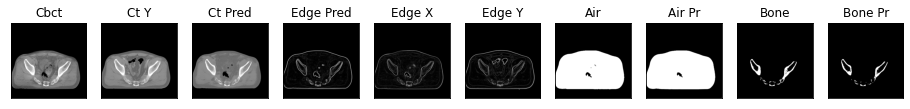

106it [00:51,  2.30it/s]

ssim score = 0.8459583520889282
psnr score = 23.55544662475586
snr score = 14.14750862121582
mae error = 0.02448524720966816
air dice score = 0.9965350201343454
bone dice score = 0.8632715599027685
contour dice score = 0.6703540086746216


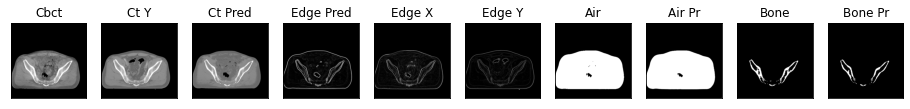

107it [00:52,  2.27it/s]

ssim score = 0.8499144911766052
psnr score = 24.062000274658203
snr score = 14.592365264892578
mae error = 0.02352166548371315
air dice score = 0.9963805628524276
bone dice score = 0.867577106032414
contour dice score = 0.700721800327301


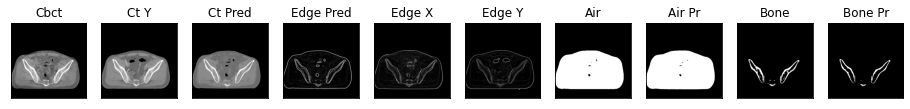

108it [00:52,  2.23it/s]

ssim score = 0.8459991812705994
psnr score = 24.134132385253906
snr score = 14.603233337402344
mae error = 0.02326170727610588
air dice score = 0.9962297359089648
bone dice score = 0.8720139218498336
contour dice score = 0.6782511472702026


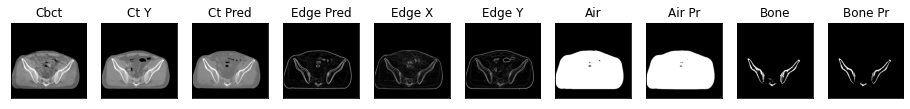

109it [00:53,  1.89it/s]

ssim score = 0.7932192087173462
psnr score = 22.53688621520996
snr score = 14.234193801879883
mae error = 0.030725250020623207
air dice score = 0.9971435344316717
bone dice score = 0.9500301023494874
contour dice score = 0.3948763310909271


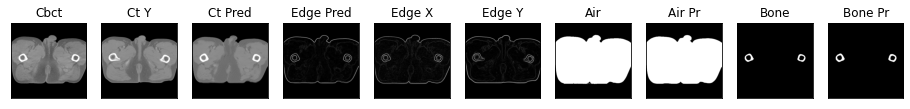

110it [00:53,  1.98it/s]

ssim score = 0.7856659889221191
psnr score = 22.27433204650879
snr score = 14.075928688049316
mae error = 0.03234552592039108
air dice score = 0.997455110985439
bone dice score = 0.950189496482128
contour dice score = 0.43028953671455383


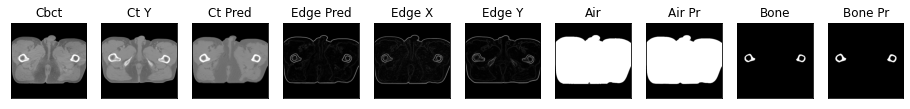

111it [00:54,  2.02it/s]

ssim score = 0.7802194952964783
psnr score = 21.962997436523438
snr score = 13.89255142211914
mae error = 0.03468960151076317
air dice score = 0.9975991875979563
bone dice score = 0.9383947939275836
contour dice score = 0.40305206179618835


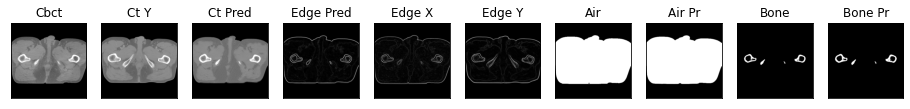

112it [00:54,  2.08it/s]

ssim score = 0.7733377814292908
psnr score = 21.601825714111328
snr score = 13.563667297363281
mae error = 0.036042798310518265
air dice score = 0.9974470975372703
bone dice score = 0.9499584372410647
contour dice score = 0.411711722612381


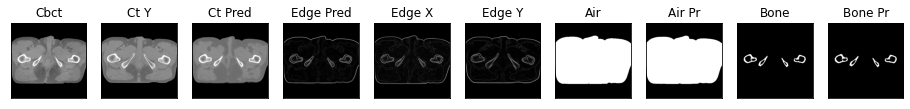

113it [00:54,  2.17it/s]

ssim score = 0.7587348818778992
psnr score = 21.349624633789062
snr score = 13.341707229614258
mae error = 0.03758816793560982
air dice score = 0.997272817524047
bone dice score = 0.9330746847731478
contour dice score = 0.4162895977497101


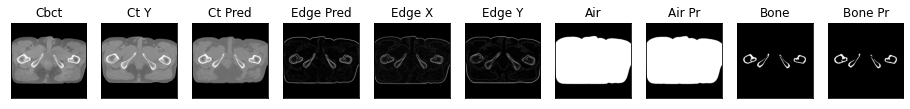

114it [00:55,  2.22it/s]

ssim score = 0.7550235986709595
psnr score = 21.27138328552246
snr score = 13.297880172729492
mae error = 0.03846906125545502
air dice score = 0.997409673269576
bone dice score = 0.9357741234884305
contour dice score = 0.4286361634731293


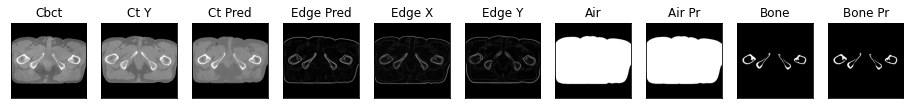

115it [00:55,  2.21it/s]

ssim score = 0.7521049380302429
psnr score = 20.952957153320312
snr score = 12.999764442443848
mae error = 0.03973277285695076
air dice score = 0.9971875742973301
bone dice score = 0.9317458119904231
contour dice score = 0.40687161684036255


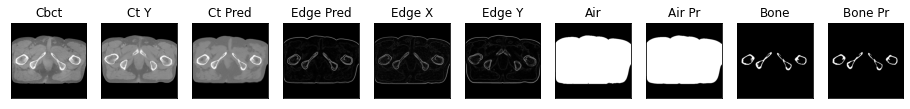

116it [00:56,  2.19it/s]

ssim score = 0.7472996711730957
psnr score = 20.734193801879883
snr score = 12.820074081420898
mae error = 0.0406191349029541
air dice score = 0.9963223157248534
bone dice score = 0.9276169265043483
contour dice score = 0.380952388048172


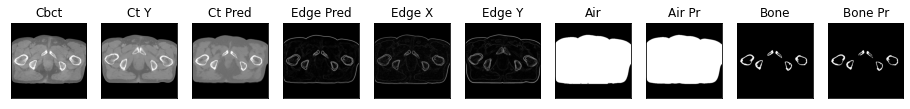

117it [00:56,  2.19it/s]

ssim score = 0.7392551898956299
psnr score = 20.642837524414062
snr score = 12.777399063110352
mae error = 0.04140477254986763
air dice score = 0.995667936941844
bone dice score = 0.9273216689108033
contour dice score = 0.3918154239654541


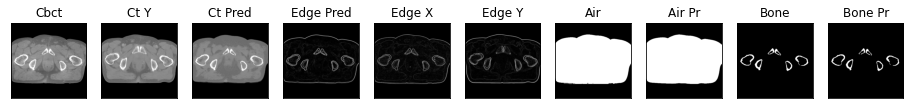

118it [00:57,  2.26it/s]

ssim score = 0.7298258543014526
psnr score = 20.39981460571289
snr score = 12.556986808776855
mae error = 0.0433531329035759
air dice score = 0.9959947213668905
bone dice score = 0.9235975530401719
contour dice score = 0.4156728982925415


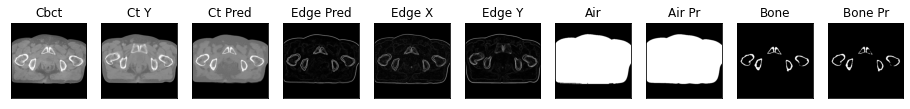

119it [00:57,  1.90it/s]

ssim score = 0.7206247448921204
psnr score = 20.435497283935547
snr score = 12.63545036315918
mae error = 0.044223662465810776
air dice score = 0.9965646452924113
bone dice score = 0.9087988136442313
contour dice score = 0.4272921085357666


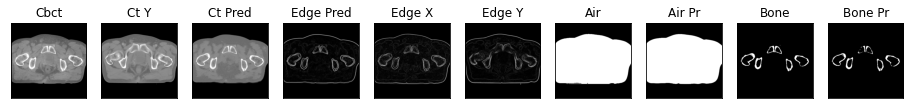

120it [00:58,  1.98it/s]

ssim score = 0.7278565168380737
psnr score = 20.57955551147461
snr score = 12.837843894958496
mae error = 0.04378269240260124
air dice score = 0.996609584112824
bone dice score = 0.9021305685325038
contour dice score = 0.38108229637145996


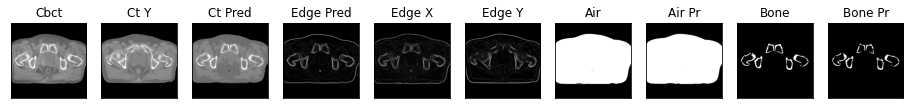

121it [00:58,  2.08it/s]

ssim score = 0.7228604555130005
psnr score = 20.45294761657715
snr score = 12.635865211486816
mae error = 0.04530041292309761
air dice score = 0.9971069507951589
bone dice score = 0.8613481228683729
contour dice score = 0.42759251594543457


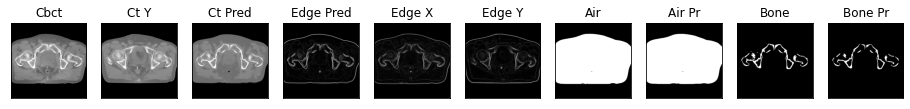

122it [00:59,  2.10it/s]

ssim score = 0.7291519045829773
psnr score = 20.501672744750977
snr score = 12.577371597290039
mae error = 0.04477483779191971
air dice score = 0.9969401019199152
bone dice score = 0.8383105802065026
contour dice score = 0.42804765701293945


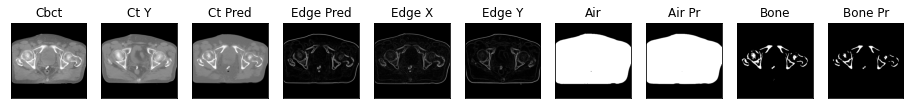

123it [00:59,  2.12it/s]

ssim score = 0.7411617636680603
psnr score = 20.877912521362305
snr score = 12.830523490905762
mae error = 0.04258282855153084
air dice score = 0.997351938841302
bone dice score = 0.7830292371973726
contour dice score = 0.4450574815273285


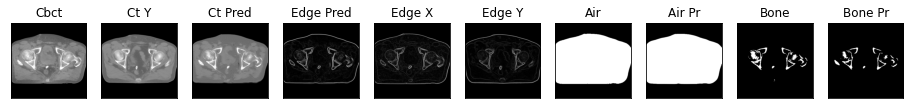

124it [01:00,  2.20it/s]

ssim score = 0.7493036985397339
psnr score = 21.136638641357422
snr score = 12.97681999206543
mae error = 0.040331270545721054
air dice score = 0.9974489795918382
bone dice score = 0.8411628164049831
contour dice score = 0.419205904006958


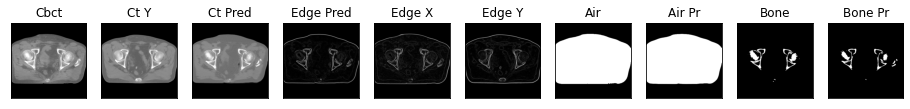

125it [01:00,  2.24it/s]

ssim score = 0.7507466673851013
psnr score = 21.38200569152832
snr score = 13.171540260314941
mae error = 0.03805912286043167
air dice score = 0.9974650724017007
bone dice score = 0.8917748917760631
contour dice score = 0.406496524810791


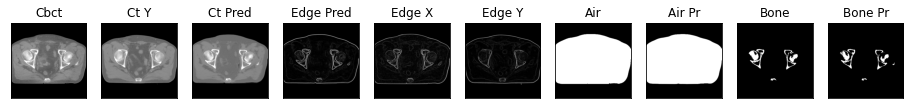

126it [01:01,  2.22it/s]

ssim score = 0.7499876022338867
psnr score = 21.226045608520508
snr score = 13.047737121582031
mae error = 0.03899490088224411
air dice score = 0.99763672997753
bone dice score = 0.8982817869427459
contour dice score = 0.44247788190841675


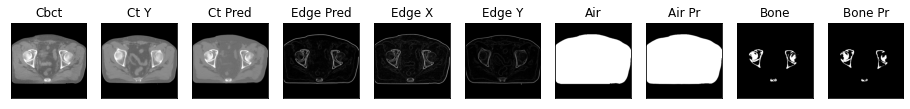

127it [01:01,  2.22it/s]

ssim score = 0.7488229870796204
psnr score = 21.037944793701172
snr score = 12.8731107711792
mae error = 0.03970532491803169
air dice score = 0.9976155357465603
bone dice score = 0.9013911116594683
contour dice score = 0.42455482482910156


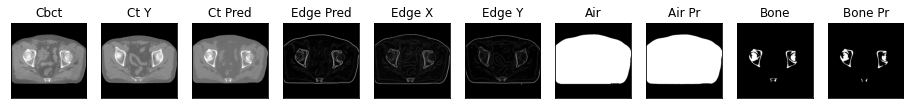

128it [01:01,  2.28it/s]

ssim score = 0.7461583018302917
psnr score = 20.671382904052734
snr score = 12.365055084228516
mae error = 0.041140247136354446
air dice score = 0.9972579945862986
bone dice score = 0.9130541268685641
contour dice score = 0.41643059253692627


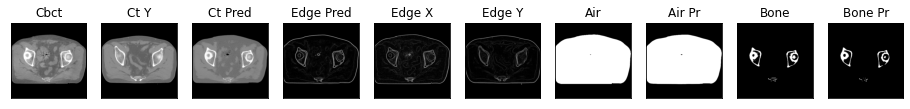

129it [01:02,  1.95it/s]

ssim score = 0.761279821395874
psnr score = 20.8405704498291
snr score = 12.47493839263916
mae error = 0.039522044360637665
air dice score = 0.9972909624150497
bone dice score = 0.9301609517154631
contour dice score = 0.3810426592826843


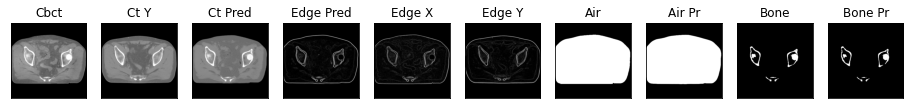

130it [01:02,  2.04it/s]

ssim score = 0.7584990859031677
psnr score = 21.16499900817871
snr score = 12.82501220703125
mae error = 0.03762095421552658
air dice score = 0.9969647305236893
bone dice score = 0.9203897775340983
contour dice score = 0.3870967626571655


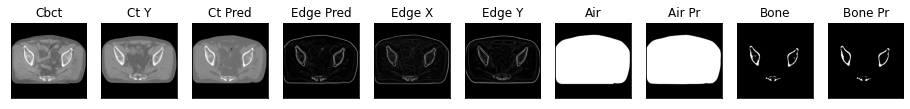

131it [01:03,  2.08it/s]

ssim score = 0.7527866959571838
psnr score = 21.045372009277344
snr score = 12.778200149536133
mae error = 0.03823324292898178
air dice score = 0.9965201149254374
bone dice score = 0.926080892609378
contour dice score = 0.3671726882457733


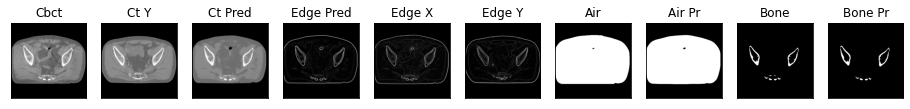

132it [01:03,  2.16it/s]

ssim score = 0.745334267616272
psnr score = 20.658039093017578
snr score = 12.520098686218262
mae error = 0.040638405829668045
air dice score = 0.9965592967801022
bone dice score = 0.9265739983658777
contour dice score = 0.38527724146842957


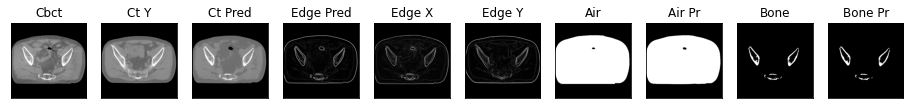

133it [01:04,  2.18it/s]

ssim score = 0.7402669191360474
psnr score = 20.42379379272461
snr score = 12.319811820983887
mae error = 0.04194089397788048
air dice score = 0.9965143369715087
bone dice score = 0.9182677645636129
contour dice score = 0.3594425618648529


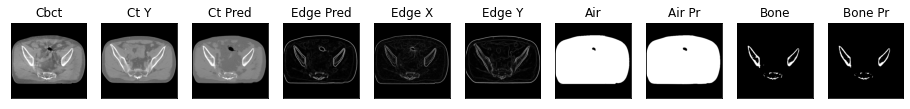

134it [01:04,  2.21it/s]

ssim score = 0.7347937226295471
psnr score = 20.58599853515625
snr score = 12.452224731445312
mae error = 0.04222690314054489
air dice score = 0.9969500226483485
bone dice score = 0.8820791311109119
contour dice score = 0.32513266801834106


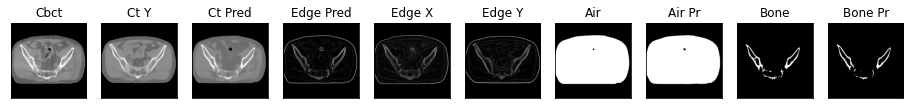

135it [01:05,  2.21it/s]

ssim score = 0.733295202255249
psnr score = 20.930965423583984
snr score = 12.733817100524902
mae error = 0.04041939973831177
air dice score = 0.9969281849632552
bone dice score = 0.8877536932225907
contour dice score = 0.34769976139068604


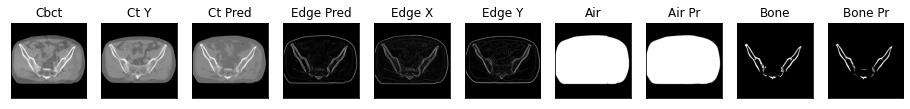

136it [01:05,  2.27it/s]

ssim score = 0.809528648853302
psnr score = 22.248050689697266
snr score = 13.725440979003906
mae error = 0.03148224204778671
air dice score = 0.9979767136790475
bone dice score = 0.8778139232286556
contour dice score = 0.5911379456520081


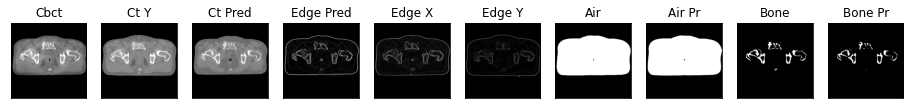

137it [01:06,  2.28it/s]

ssim score = 0.8107225894927979
psnr score = 22.2501277923584
snr score = 13.767529487609863
mae error = 0.031877342611551285
air dice score = 0.9980170076868818
bone dice score = 0.8614293507929428
contour dice score = 0.5767676830291748


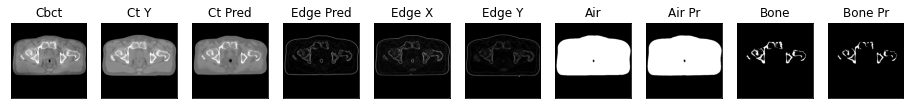

138it [01:06,  2.25it/s]

ssim score = 0.8121756911277771
psnr score = 22.307632446289062
snr score = 13.8328218460083
mae error = 0.03203706815838814
air dice score = 0.9974140237196464
bone dice score = 0.8540249433127264
contour dice score = 0.5785207748413086


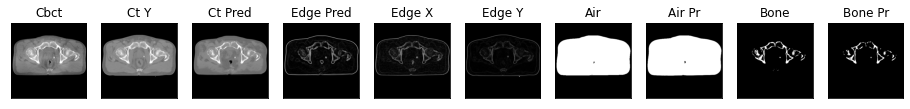

139it [01:07,  1.92it/s]

ssim score = 0.8135684728622437
psnr score = 22.352848052978516
snr score = 13.819618225097656
mae error = 0.031080249696969986
air dice score = 0.9972112860892409
bone dice score = 0.8534656120142986
contour dice score = 0.5792682766914368


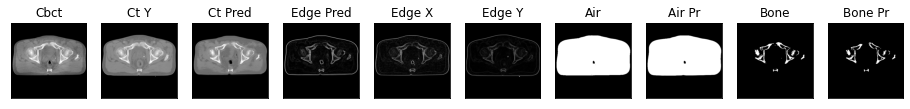

140it [01:07,  2.05it/s]

ssim score = 0.8203870058059692
psnr score = 22.563257217407227
snr score = 13.874402046203613
mae error = 0.02852226234972477
air dice score = 0.997038543801136
bone dice score = 0.8856214208344587
contour dice score = 0.5507394075393677


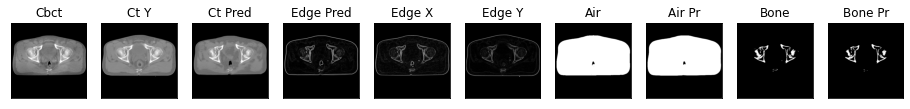

141it [01:08,  2.11it/s]

ssim score = 0.8250698447227478
psnr score = 22.722537994384766
snr score = 14.012879371643066
mae error = 0.027772331610322
air dice score = 0.9970837175479259
bone dice score = 0.891872172772627
contour dice score = 0.5248081684112549


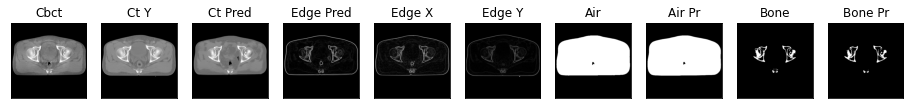

142it [01:08,  2.13it/s]

ssim score = 0.823068380355835
psnr score = 22.822219848632812
snr score = 14.096931457519531
mae error = 0.027355197817087173
air dice score = 0.9972035962353811
bone dice score = 0.8930909090924641
contour dice score = 0.48715314269065857


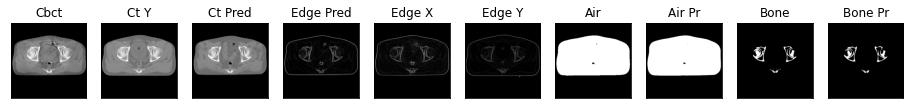

143it [01:08,  2.14it/s]

ssim score = 0.8196259140968323
psnr score = 22.313539505004883
snr score = 13.597617149353027
mae error = 0.028833920136094093
air dice score = 0.9973041344157091
bone dice score = 0.8789224393149953
contour dice score = 0.5494845509529114


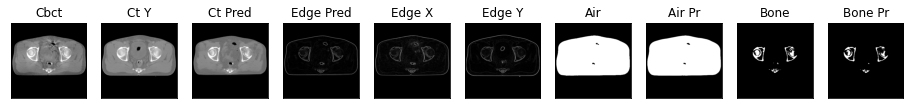

144it [01:09,  2.23it/s]

ssim score = 0.8147346377372742
psnr score = 22.25653076171875
snr score = 13.596390724182129
mae error = 0.030180441215634346
air dice score = 0.997572430065569
bone dice score = 0.8828273940477661
contour dice score = 0.5569358468055725


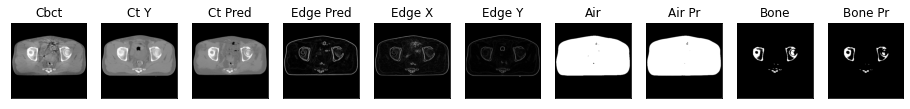

145it [01:09,  2.32it/s]

ssim score = 0.8151400089263916
psnr score = 21.962074279785156
snr score = 13.280004501342773
mae error = 0.030936921015381813
air dice score = 0.9972037324093513
bone dice score = 0.8975391498896713
contour dice score = 0.5862785577774048


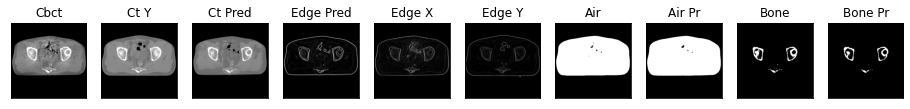

146it [01:10,  2.39it/s]

ssim score = 0.8164796233177185
psnr score = 21.595497131347656
snr score = 12.8426513671875
mae error = 0.03166394308209419
air dice score = 0.9971248808388964
bone dice score = 0.8702315508933828
contour dice score = 0.6109660863876343


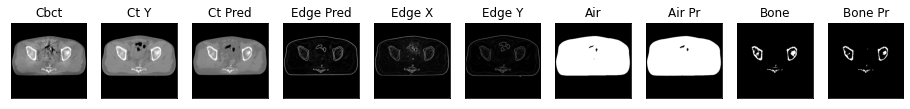

147it [01:10,  2.35it/s]

ssim score = 0.816836953163147
psnr score = 21.795757293701172
snr score = 12.999015808105469
mae error = 0.030540386214852333
air dice score = 0.9972606084654086
bone dice score = 0.8828576431468594
contour dice score = 0.6169989705085754


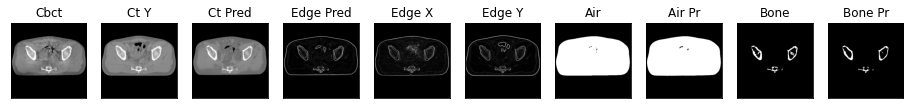

148it [01:10,  2.44it/s]

ssim score = 0.815686821937561
psnr score = 22.050308227539062
snr score = 13.252472877502441
mae error = 0.029708951711654663
air dice score = 0.9970981202863619
bone dice score = 0.897807757168671
contour dice score = 0.6003159284591675


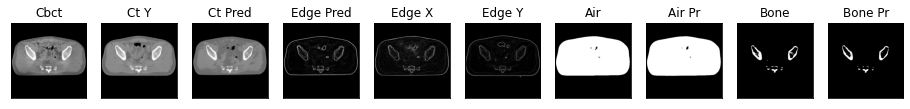

149it [01:11,  2.04it/s]

ssim score = 0.8147812485694885
psnr score = 21.976482391357422
snr score = 13.192005157470703
mae error = 0.03007638081908226
air dice score = 0.9963782881836873
bone dice score = 0.9068042566928926
contour dice score = 0.6051660776138306


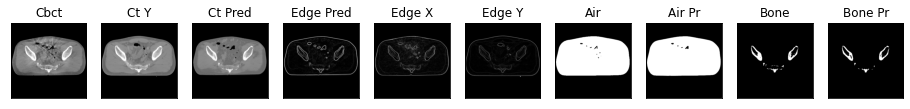

150it [01:12,  2.18it/s]

ssim score = 0.8108629584312439
psnr score = 21.8065242767334
snr score = 13.077249526977539
mae error = 0.03116961009800434
air dice score = 0.9964304478165494
bone dice score = 0.8796334860491513
contour dice score = 0.6194503307342529


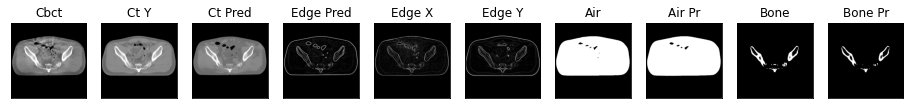

151it [01:12,  1.93it/s]

ssim score = 0.8127639293670654
psnr score = 21.48251724243164
snr score = 12.772613525390625
mae error = 0.03249457851052284
air dice score = 0.9960418586997808
bone dice score = 0.8732876712346849
contour dice score = 0.6161187887191772


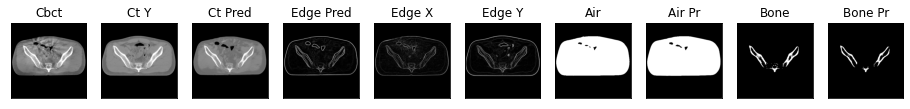

152it [01:13,  1.63it/s]

ssim score = 0.8166633248329163
psnr score = 21.679927825927734
snr score = 12.91528606414795
mae error = 0.03170254826545715
air dice score = 0.996371457529035
bone dice score = 0.8839491031751656
contour dice score = 0.5568544268608093


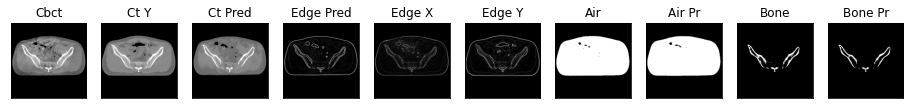

153it [01:13,  1.81it/s]

ssim score = 0.8200952410697937
psnr score = 21.88296890258789
snr score = 13.081972122192383
mae error = 0.030684543773531914
air dice score = 0.9970384689735187
bone dice score = 0.8734856617102671
contour dice score = 0.5154749155044556


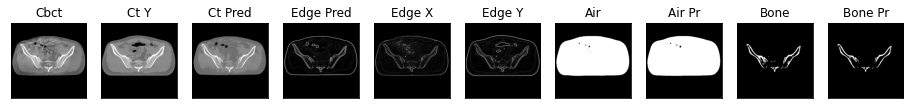

154it [01:14,  1.96it/s]

ssim score = 0.8229876756668091
psnr score = 22.089662551879883
snr score = 13.288740158081055
mae error = 0.029680831357836723
air dice score = 0.9967200433201852
bone dice score = 0.8524405682957878
contour dice score = 0.4847185015678406


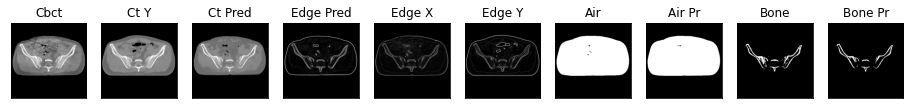

155it [01:14,  2.06it/s]

ssim score = 0.8240485787391663
psnr score = 22.086753845214844
snr score = 13.284406661987305
mae error = 0.029743900522589684
air dice score = 0.9970466260997659
bone dice score = 0.8694066489006956
contour dice score = 0.5118534564971924


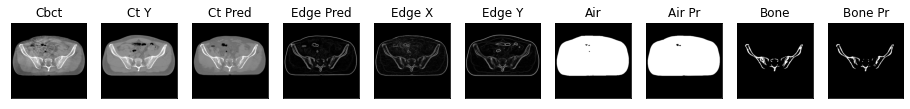

156it [01:15,  2.14it/s]

ssim score = 0.8167566657066345
psnr score = 21.44941520690918
snr score = 12.652109146118164
mae error = 0.031536731868982315
air dice score = 0.9964829281957138
bone dice score = 0.8606475538459472
contour dice score = 0.5311653017997742


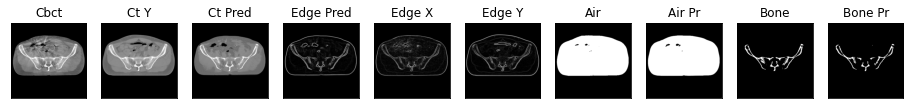

157it [01:15,  2.24it/s]

ssim score = 0.8112268447875977
psnr score = 21.02407455444336
snr score = 12.209493637084961
mae error = 0.03306767717003822
air dice score = 0.9952671146609962
bone dice score = 0.8612889457979614
contour dice score = 0.5753275156021118


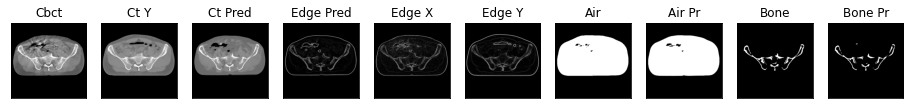

158it [01:15,  2.35it/s]

ssim score = 0.8103125095367432
psnr score = 21.066892623901367
snr score = 12.233688354492188
mae error = 0.03326844051480293
air dice score = 0.9956997347646659
bone dice score = 0.8296786650140715
contour dice score = 0.584294319152832


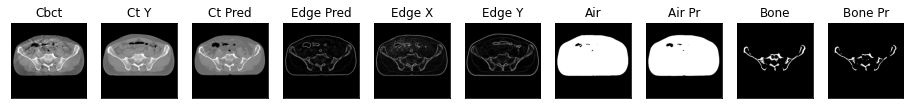

159it [01:16,  2.09it/s]

ssim score = 0.8024606108665466
psnr score = 20.687379837036133
snr score = 11.808238983154297
mae error = 0.03453260287642479
air dice score = 0.9949280156254963
bone dice score = 0.8080971659944927
contour dice score = 0.5491712689399719


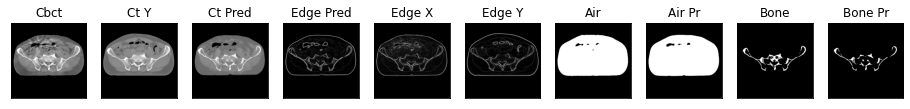

160it [01:17,  2.19it/s]

ssim score = 0.7988142371177673
psnr score = 20.657875061035156
snr score = 11.724934577941895
mae error = 0.034525781869888306
air dice score = 0.9947543733335484
bone dice score = 0.8292111429337515
contour dice score = 0.5236242413520813


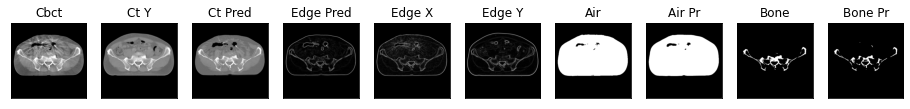

161it [01:17,  2.28it/s]

ssim score = 0.7887589335441589
psnr score = 20.32537841796875
snr score = 11.422903060913086
mae error = 0.0365426167845726
air dice score = 0.9948679652991874
bone dice score = 0.85339057962049
contour dice score = 0.5075292587280273


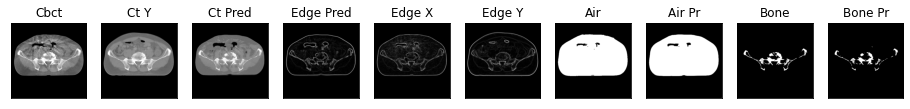

162it [01:17,  2.31it/s]

ssim score = 0.784898042678833
psnr score = 20.12212562561035
snr score = 11.164422988891602
mae error = 0.03658421337604523
air dice score = 0.9951051789594366
bone dice score = 0.8538088370282705
contour dice score = 0.523676872253418


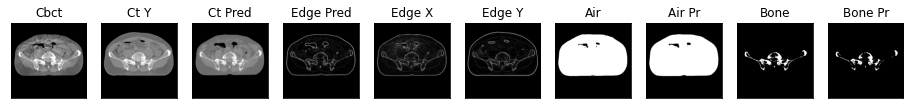

163it [01:18,  2.32it/s]

ssim score = 0.7960273623466492
psnr score = 20.862367630004883
snr score = 11.757134437561035
mae error = 0.03287558630108833
air dice score = 0.9959293572208137
bone dice score = 0.8693644758301281
contour dice score = 0.45490196347236633


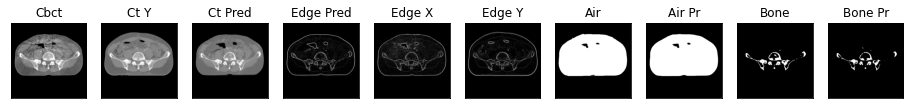

164it [01:18,  2.33it/s]

ssim score = 0.8413917422294617
psnr score = 24.570722579956055
snr score = 14.951637268066406
mae error = 0.022741660475730896
air dice score = 0.9949693142924622
bone dice score = 0.9344049779638475
contour dice score = 0.43926140666007996


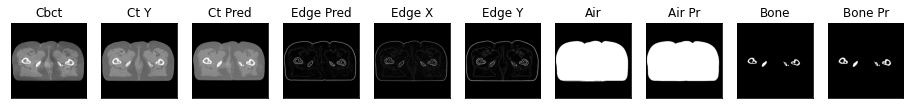

165it [01:19,  2.36it/s]

ssim score = 0.8432719707489014
psnr score = 24.73516273498535
snr score = 15.23708724975586
mae error = 0.022535132244229317
air dice score = 0.9952805991587189
bone dice score = 0.9370846256106096
contour dice score = 0.447524756193161


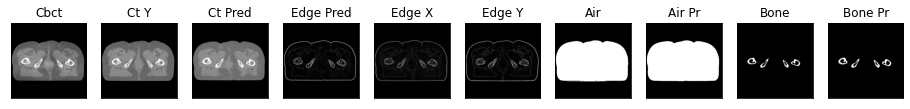

166it [01:19,  2.44it/s]

ssim score = 0.837441086769104
psnr score = 24.659439086914062
snr score = 15.244278907775879
mae error = 0.022859560325741768
air dice score = 0.9953755962567852
bone dice score = 0.9245967741950686
contour dice score = 0.4166259169578552


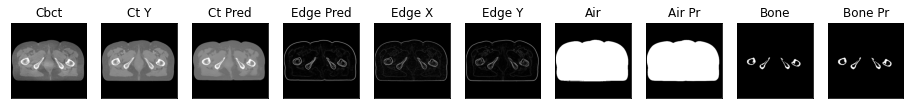

167it [01:19,  2.50it/s]

ssim score = 0.8325498700141907
psnr score = 24.56535530090332
snr score = 15.213643074035645
mae error = 0.02309584990143776
air dice score = 0.9955136800144986
bone dice score = 0.924840764332578
contour dice score = 0.4301075339317322


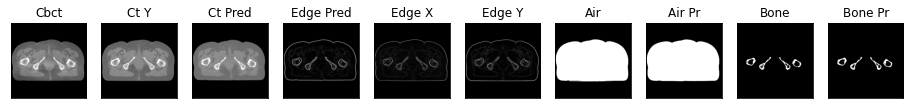

168it [01:20,  2.54it/s]

ssim score = 0.8324347734451294
psnr score = 24.473278045654297
snr score = 15.15002727508545
mae error = 0.023397216573357582
air dice score = 0.9953187308559244
bone dice score = 0.9316120027925399
contour dice score = 0.4051256775856018


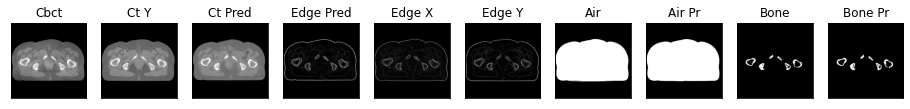

169it [01:20,  2.11it/s]

ssim score = 0.8335067629814148
psnr score = 24.407272338867188
snr score = 15.106975555419922
mae error = 0.023301411420106888
air dice score = 0.9953378441672645
bone dice score = 0.9314969191748551
contour dice score = 0.40195122361183167


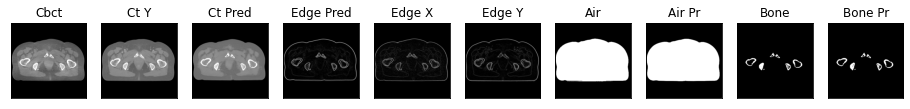

170it [01:21,  2.24it/s]

ssim score = 0.8308531641960144
psnr score = 24.334407806396484
snr score = 15.065436363220215
mae error = 0.0232862439006567
air dice score = 0.9952836293047701
bone dice score = 0.9175882982533431
contour dice score = 0.3775411546230316


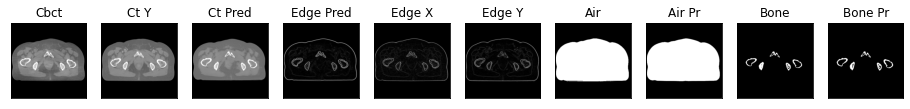

171it [01:21,  2.28it/s]

ssim score = 0.830897331237793
psnr score = 24.124786376953125
snr score = 14.904179573059082
mae error = 0.023913465440273285
air dice score = 0.9953552481388721
bone dice score = 0.9274392391699993
contour dice score = 0.37323281168937683


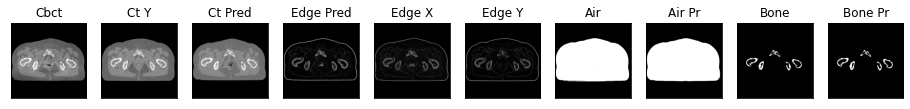

172it [01:22,  2.30it/s]

ssim score = 0.8317143321037292
psnr score = 23.727554321289062
snr score = 14.54969310760498
mae error = 0.024655330926179886
air dice score = 0.995020800551811
bone dice score = 0.925710486954866
contour dice score = 0.39923039078712463


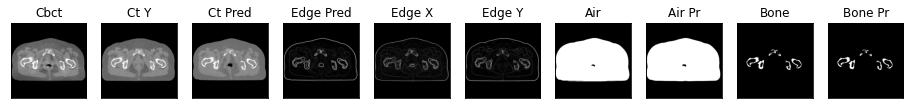

173it [01:22,  2.31it/s]

ssim score = 0.8298677206039429
psnr score = 23.641773223876953
snr score = 14.551612854003906
mae error = 0.02501056343317032
air dice score = 0.9947622913717948
bone dice score = 0.9131014063669415
contour dice score = 0.37827715277671814


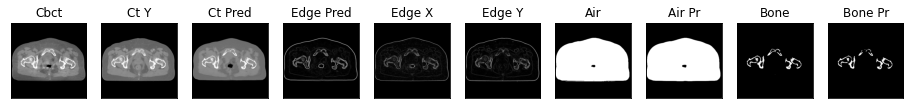

174it [01:22,  2.35it/s]

ssim score = 0.8288235068321228
psnr score = 24.34497833251953
snr score = 15.36808967590332
mae error = 0.024115638807415962
air dice score = 0.9944943370323801
bone dice score = 0.9025407660232266
contour dice score = 0.35968562960624695


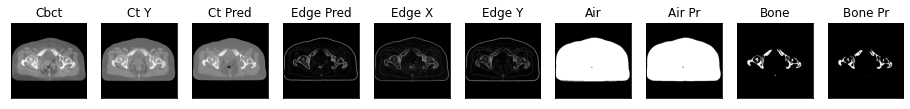

175it [01:23,  2.43it/s]

ssim score = 0.8274683952331543
psnr score = 23.6782283782959
snr score = 14.572790145874023
mae error = 0.024917077273130417
air dice score = 0.9941373774439581
bone dice score = 0.9082910321504519
contour dice score = 0.37037035822868347


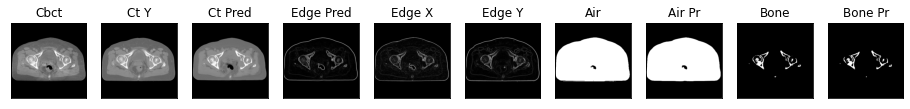

176it [01:23,  2.50it/s]

ssim score = 0.8293015956878662
psnr score = 23.620277404785156
snr score = 14.405413627624512
mae error = 0.025086965411901474
air dice score = 0.9942995459688664
bone dice score = 0.8975537980522796
contour dice score = 0.3678053319454193


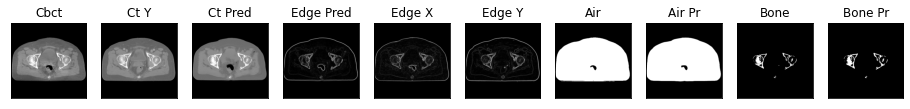

177it [01:24,  2.45it/s]

ssim score = 0.832588791847229
psnr score = 23.719947814941406
snr score = 14.477959632873535
mae error = 0.025627855211496353
air dice score = 0.9948119232992494
bone dice score = 0.9082895406016563
contour dice score = 0.3902662992477417


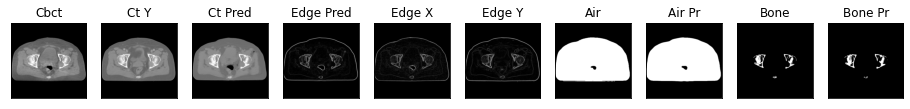

178it [01:24,  2.41it/s]

ssim score = 0.8361948132514954
psnr score = 24.273792266845703
snr score = 15.023797988891602
mae error = 0.02536112815141678
air dice score = 0.9951185692455748
bone dice score = 0.927818061965593
contour dice score = 0.3917718529701233


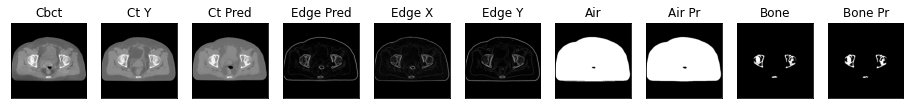

179it [01:25,  2.04it/s]

ssim score = 0.836747944355011
psnr score = 25.026018142700195
snr score = 15.81025505065918
mae error = 0.023397479206323624
air dice score = 0.995307666949566
bone dice score = 0.9390975071009925
contour dice score = 0.40037772059440613


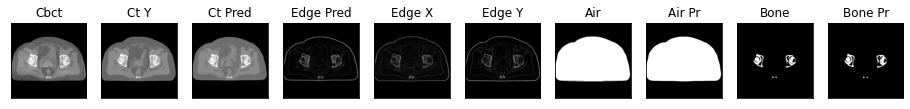

180it [01:25,  2.13it/s]

ssim score = 0.8292977809906006
psnr score = 24.531248092651367
snr score = 15.366975784301758
mae error = 0.02470552548766136
air dice score = 0.9956828120212826
bone dice score = 0.9512664315493545
contour dice score = 0.3886210322380066


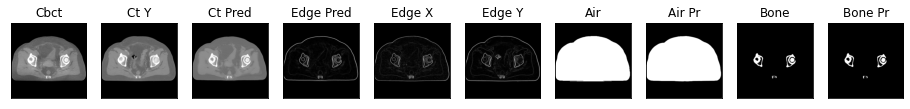

181it [01:26,  2.19it/s]

ssim score = 0.8199273347854614
psnr score = 23.80396270751953
snr score = 14.67724895477295
mae error = 0.026177018880844116
air dice score = 0.9959328541144491
bone dice score = 0.9492703266165867
contour dice score = 0.393410861492157


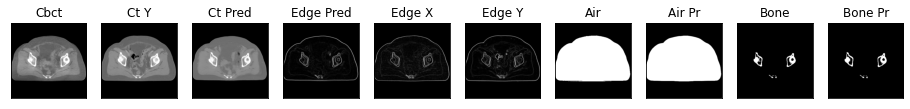

182it [01:26,  2.27it/s]

ssim score = 0.8083194494247437
psnr score = 22.607736587524414
snr score = 13.408586502075195
mae error = 0.02899579517543316
air dice score = 0.9957116825823099
bone dice score = 0.9269978401743629
contour dice score = 0.38608524203300476


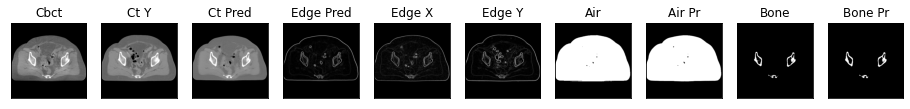

183it [01:26,  2.37it/s]

ssim score = 0.8030396103858948
psnr score = 22.319541931152344
snr score = 13.102398872375488
mae error = 0.030058307573199272
air dice score = 0.9955905103967208
bone dice score = 0.9342530717841291
contour dice score = 0.4019801914691925


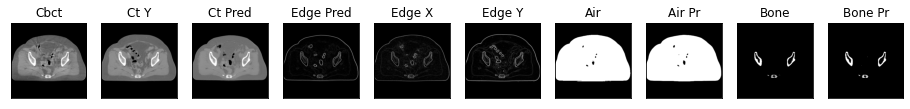

184it [01:27,  2.45it/s]

ssim score = 0.8012144565582275
psnr score = 22.840024948120117
snr score = 13.687796592712402
mae error = 0.029435545206069946
air dice score = 0.9958074952817499
bone dice score = 0.9355509355522754
contour dice score = 0.3908956050872803


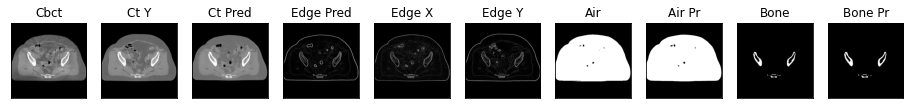

185it [01:27,  2.41it/s]

ssim score = 0.8026909232139587
psnr score = 22.931976318359375
snr score = 13.834842681884766
mae error = 0.029306577518582344
air dice score = 0.9955289415821829
bone dice score = 0.9447236180914443
contour dice score = 0.3882235586643219


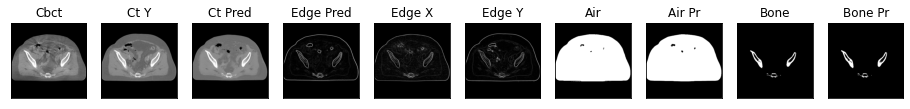

186it [01:28,  2.39it/s]

ssim score = 0.7978314757347107
psnr score = 22.21446990966797
snr score = 13.181764602661133
mae error = 0.03162635490298271
air dice score = 0.9956437111873233
bone dice score = 0.9391143911448475
contour dice score = 0.38719213008880615


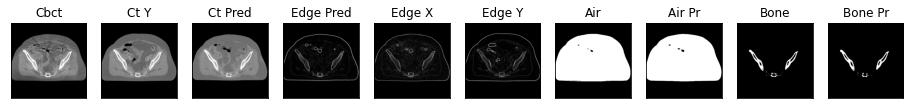

187it [01:28,  2.37it/s]

ssim score = 0.794607937335968
psnr score = 22.018970489501953
snr score = 13.059124946594238
mae error = 0.032501157373189926
air dice score = 0.9956923157742696
bone dice score = 0.9180985108831887
contour dice score = 0.37747034430503845


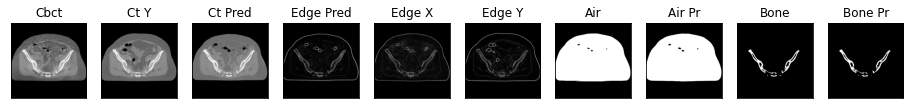

188it [01:28,  2.41it/s]

ssim score = 0.7961894869804382
psnr score = 22.021284103393555
snr score = 13.057147979736328
mae error = 0.032821688801050186
air dice score = 0.9953029009961007
bone dice score = 0.905786565863539
contour dice score = 0.37964776158332825


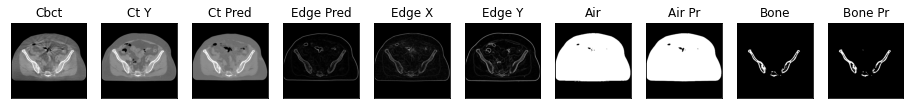

189it [01:29,  2.12it/s]

ssim score = 0.7962365746498108
psnr score = 22.241737365722656
snr score = 13.255425453186035
mae error = 0.03283842280507088
air dice score = 0.9956960244687812
bone dice score = 0.9062411748106998
contour dice score = 0.35214006900787354


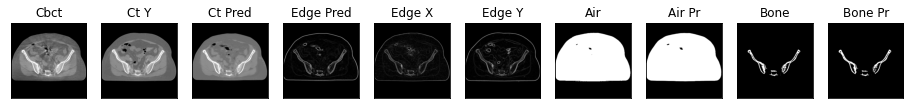

190it [01:29,  2.19it/s]

ssim score = 0.8023738265037537
psnr score = 22.868806838989258
snr score = 13.894129753112793
mae error = 0.03133489191532135
air dice score = 0.9960735662761574
bone dice score = 0.917232413694681
contour dice score = 0.36425119638442993


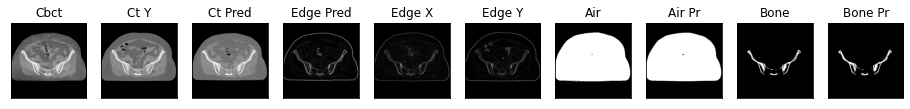

191it [01:30,  2.11it/s]


In [44]:
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=4)
test_epoch(model, testloader, device, True, os.path.join("eval-gan", wandb.run.name))

In [45]:
tf_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
replace_relu_to_leakyReLU(tf_discriminator)
replace_bn_to_instanceNorm(tf_discriminator)
tf_discriminator.load_state_dict(checkpoint["tf_discriminator"])

<All keys matched successfully>

In [46]:
edge_discriminator = Discriminator(in_channel=E_IN_CHANNELS, n_classes=E_N_CLASSES, activation=E_ACT)
replace_relu_to_leakyReLU(edge_discriminator)
replace_bn_to_instanceNorm(edge_discriminator)
edge_discriminator.load_state_dict(checkpoint["edge_discriminator"])

<All keys matched successfully>

In [47]:
# score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, \
#             score_air_test, score_bone_test, score_cont_test, score_tf_acc_test, score_edge_acc_test
eval_epoch(model, tf_discriminator, edge_discriminator, testloader, device)

191it [00:16, 11.78it/s]


(0.8191732455298538,
 22.932608259910065,
 13.936880376326476,
 0.028874222091667314,
 0.996185337722732,
 0.8902790042005431,
 0.50280736815867,
 0.5062354566608492,
 0.4997636707388016)

In [48]:
# import torchvision.models as models
# models.vgg16(pretrained=True)